In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, LabelBinarizer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score 

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

In [2]:
# get all data from csv files
diagnosis_data = pd.read_csv('Diagnosisdata.csv') 
hospital_data = pd.read_csv('Hospitaldata.csv') 
patient_data = pd.read_csv('Patientdata.csv') 

In [3]:
# merge all into single df
all_features = diagnosis_data.merge(hospital_data,on=['patientID','istrain']).merge(patient_data,on=['patientID','istrain'])

In [4]:
all_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31513 entries, 0 to 31512
Data columns (total 41 columns):
patientID                  31513 non-null object
num_procedures             31513 non-null int64
num_medications            31513 non-null int64
num_diagnoses              31513 non-null int64
max_glu_serum              31513 non-null object
A1Cresult                  31513 non-null object
metformin                  31513 non-null object
repaglinide                31513 non-null object
nateglinide                31513 non-null object
chlorpropamide             31513 non-null object
glimepiride                31513 non-null object
acetohexamide              31513 non-null object
glipizide                  31513 non-null object
glyburide                  31513 non-null object
tolbutamide                31513 non-null object
pioglitazone               31513 non-null object
rosiglitazone              31513 non-null object
acarbose                   31513 non-null object
miglitol    

In [5]:
# admissionID is only identifier
all_features = all_features.drop(columns=['AdmissionID'])

In [6]:
# Missing values:
# weight has too less values. It cannot be used as a feature
all_features = all_features.drop(columns='weight')

In [7]:
# payer_code and medical_specialty have missing values. They are removed from features
all_features = all_features.drop(columns=['payer_code','medical_specialty'])

In [8]:
all_features.columns

Index(['patientID', 'num_procedures', 'num_medications', 'num_diagnoses',
       'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide.metformin', 'glipizide.metformin', 'metformin.rosiglitazone',
       'metformin.pioglitazone', 'change', 'diabetesMed', 'istrain',
       'Admission_date', 'Discharge_date', 'admission_type_id',
       'admission_source_id', 'race', 'gender', 'age', 'Target'],
      dtype='object')

In [9]:
# combine admission date and discharge date cols to duration of stay
date_list = ['Admission_date','Discharge_date']
for col in date_list:
    all_features[col] = all_features[col].astype('datetime64')

In [10]:
all_features['duration_of_stay'] = all_features['Discharge_date'] - all_features['Admission_date']
all_features['duration_of_stay'] = all_features['duration_of_stay']/np.timedelta64(1, 'D')
all_features = all_features.drop(columns=date_list)

In [11]:
all_features.columns

Index(['patientID', 'num_procedures', 'num_medications', 'num_diagnoses',
       'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide.metformin', 'glipizide.metformin', 'metformin.rosiglitazone',
       'metformin.pioglitazone', 'change', 'diabetesMed', 'istrain',
       'admission_type_id', 'admission_source_id', 'race', 'gender', 'age',
       'Target', 'duration_of_stay'],
      dtype='object')

In [12]:
# acetohexamide and metformin.rosiglitazone have same value for all samples. So it can be skipped from feature selection
all_features = all_features.drop(columns=['acetohexamide','metformin.rosiglitazone'])

In [13]:
all_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31513 entries, 0 to 31512
Data columns (total 34 columns):
patientID                 31513 non-null object
num_procedures            31513 non-null int64
num_medications           31513 non-null int64
num_diagnoses             31513 non-null int64
max_glu_serum             31513 non-null object
A1Cresult                 31513 non-null object
metformin                 31513 non-null object
repaglinide               31513 non-null object
nateglinide               31513 non-null object
chlorpropamide            31513 non-null object
glimepiride               31513 non-null object
glipizide                 31513 non-null object
glyburide                 31513 non-null object
tolbutamide               31513 non-null object
pioglitazone              31513 non-null object
rosiglitazone             31513 non-null object
acarbose                  31513 non-null object
miglitol                  31513 non-null object
troglitazone              3151

In [14]:
high_cardinality =['num_medications', 'num_diagnoses', 'admission_source_id', 'duration_of_stay','age']
numerical_categorical = ['max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'insulin', 'glyburide.metformin', 'glipizide.metformin', 'metformin.pioglitazone', 'change', 'diabetesMed', 'admission_type_id', 'race', 'gender', 'age', 'Target']

In [15]:
for col in all_features.columns:
    print(col)
    print(all_features[col].unique())

patientID
['PT456611' 'PT956824' 'PT453330' ... 'PT247544' 'PT610717' 'PT859520']
num_procedures
[0 1 2 3 6 5 4]
num_medications
[11  6 27 10 12  7 16  5 15 26 13  4 20 25 19  9 24 21 14 22 17  3 43  8
 18 31 23 28 35  2 60 46 30 33 34 38 29 48 37 39 32 41 55  1 42 51 53 45
 40 36 47 44 58 49 56 63 50 52 59 64 57 54 68 72 62 65 61 81 70 67]
num_diagnoses
[ 9  6  5  8  3  4  7  2  1 16 10 13 12 15 14]
max_glu_serum
['None' '>200' 'Norm' '>300']
A1Cresult
['None' '>8' 'Norm' '>7']
metformin
['No' 'Steady' 'Up' 'Down']
repaglinide
['No' 'Steady' 'Up' 'Down']
nateglinide
['No' 'Steady' 'Down' 'Up']
chlorpropamide
['No' 'Steady' 'Up' 'Down']
glimepiride
['No' 'Steady' 'Up' 'Down']
glipizide
['No' 'Steady' 'Up' 'Down']
glyburide
['No' 'Steady' 'Up' 'Down']
tolbutamide
['No' 'Steady']
pioglitazone
['No' 'Steady' 'Up' 'Down']
rosiglitazone
['Steady' 'No' 'Up' 'Down']
acarbose
['No' 'Steady' 'Up']
miglitol
['No' 'Steady']
troglitazone
['No' 'Steady']
tolazamide
['No' 'Steady']
insulin
['Steady'

In [16]:
# convert numerical data types to int/float by encoding
cat = all_features.columns[all_features.dtypes==object].tolist()
num = all_features.columns[all_features.dtypes!=object].tolist()
# types of categorical features
nominal = ['max_glu_serum','A1Cresult','race','age']
ordinal = ['insulin','metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide','pioglitazone', 'rosiglitazone', 'acarbose','glyburide.metformin']
binary = ['gender','tolbutamide','miglitol', 'troglitazone', 'tolazamide','glipizide.metformin','metformin.pioglitazone','change','diabetesMed']

In [17]:
# label encoding and ordinal encoding
le = LabelEncoder()
oc = OrdinalEncoder()

for col in nominal:
    all_features[col] = le.fit_transform(all_features[col])

all_features[ordinal] = oc.fit_transform(all_features[ordinal])

In [18]:
# get dummies for binary vars
all_features[binary] = pd.get_dummies(all_features[binary],columns=binary,drop_first=True)

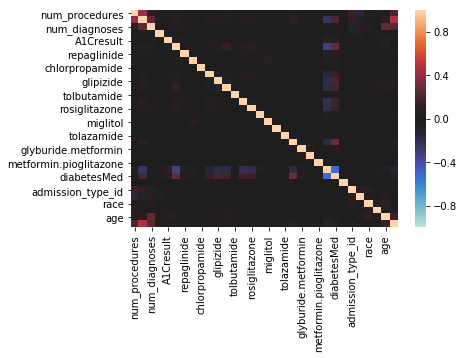

In [19]:
# correlation heatmap
corr = all_features.corr()
ax = sns.heatmap(corr, vmin=-1, vmax=1, center=0)
sns.set(rc={'figure.figsize':(11,11)})

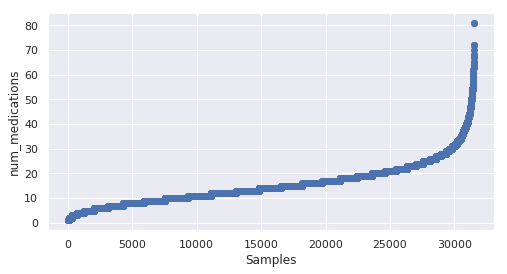

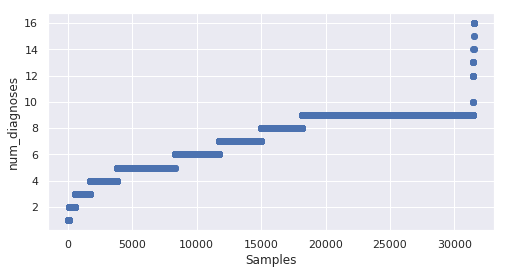

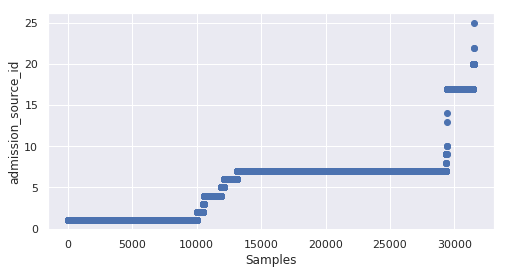

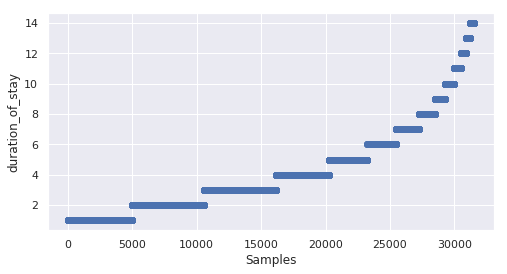

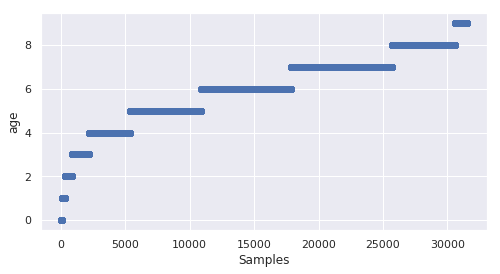

In [20]:
# high_cardinality
for y in high_cardinality:
    plt.figure(figsize=(8,4))
    plt.scatter(range(all_features.shape[0]), np.sort(all_features[y].values))
    plt.xlabel('Samples')
    plt.ylabel(y)
    plt.show();

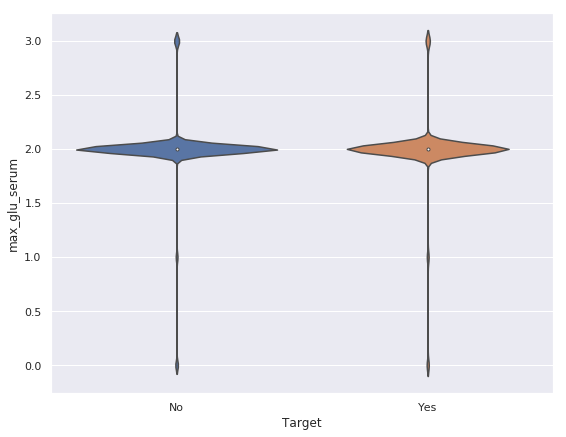

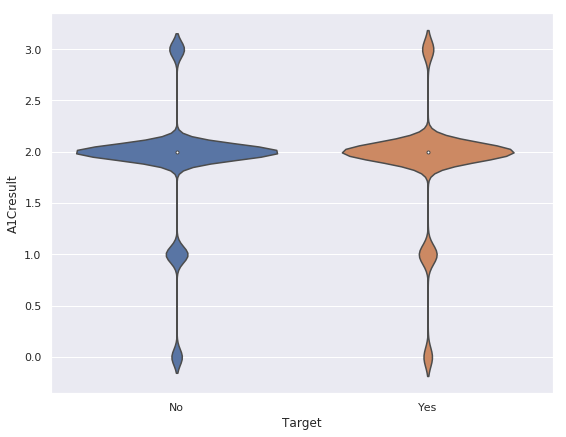

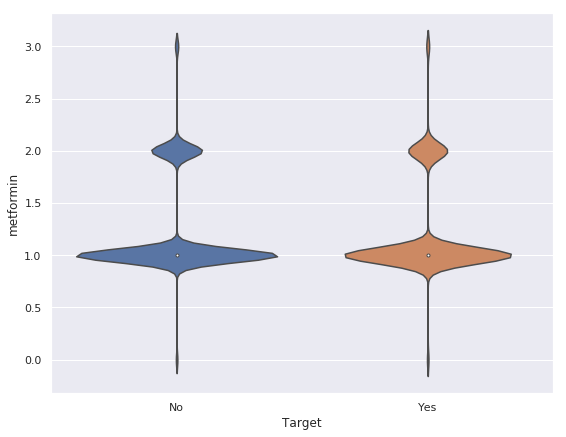

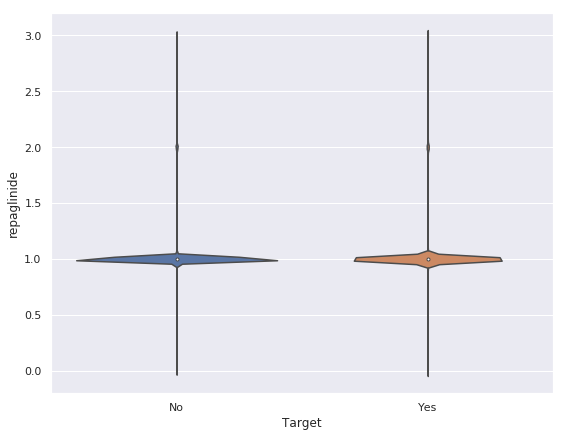

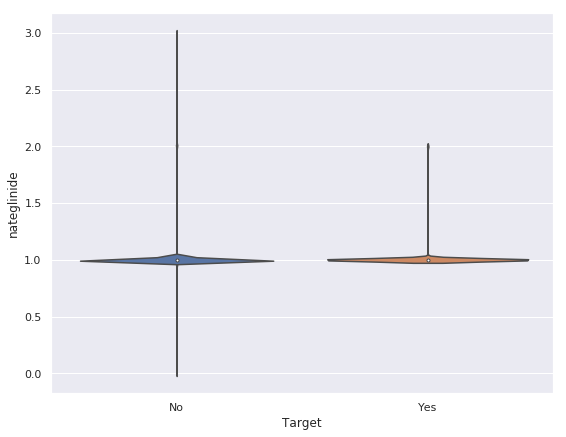

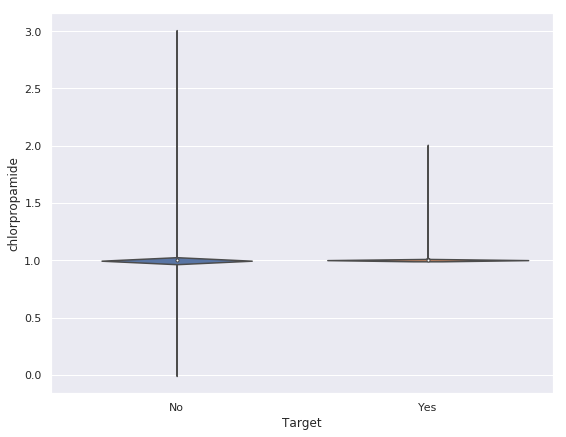

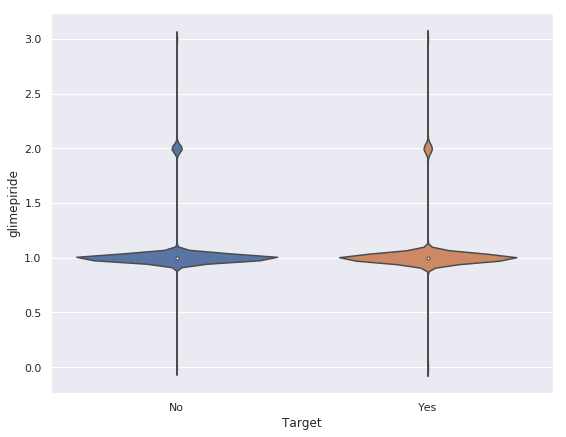

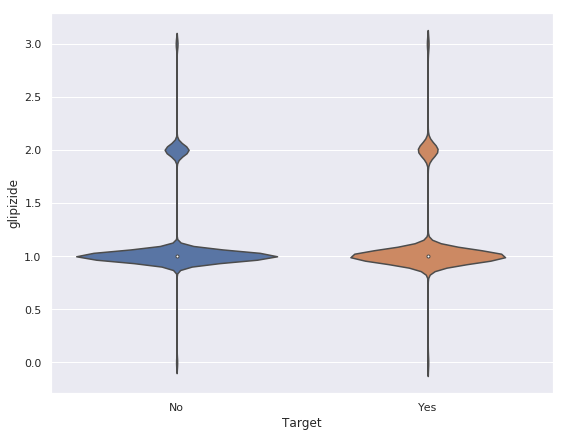

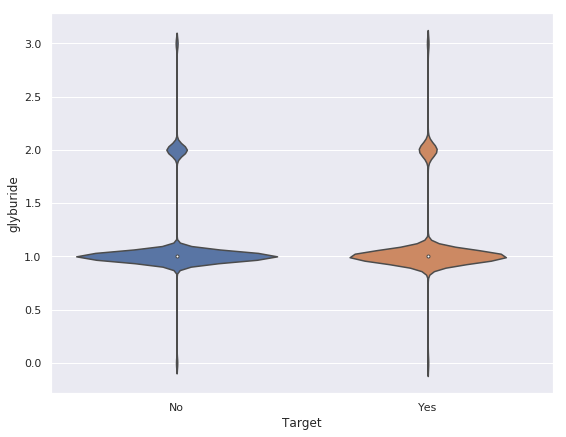

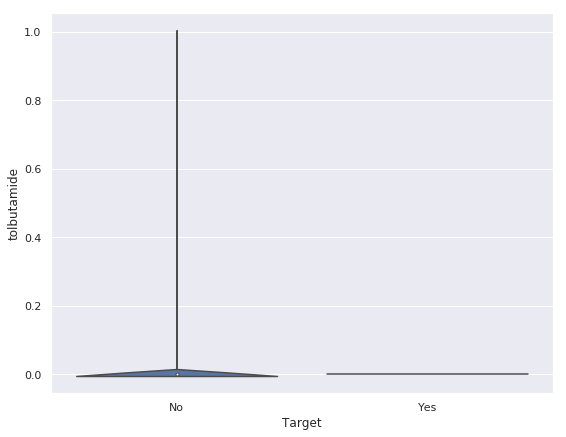

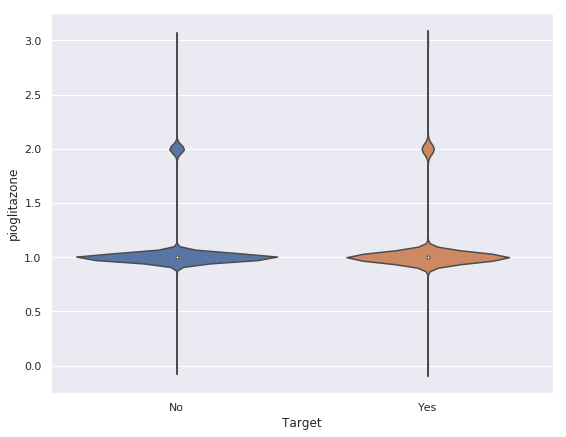

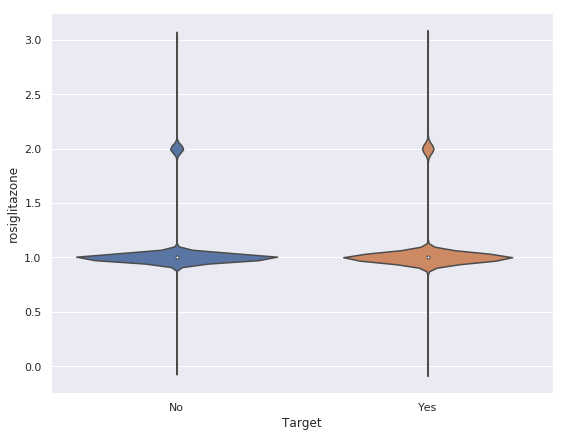

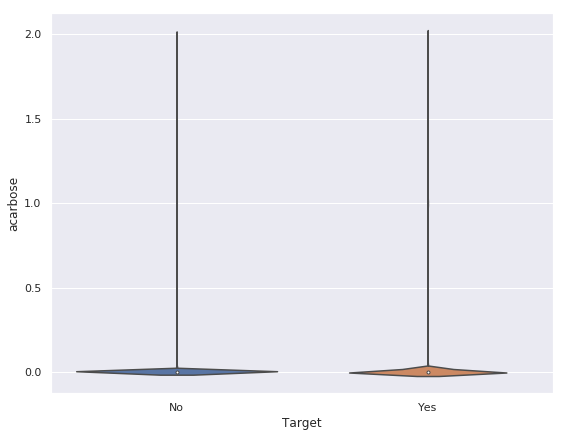

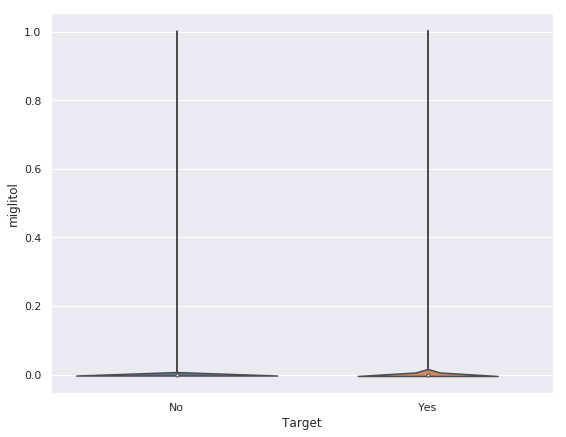

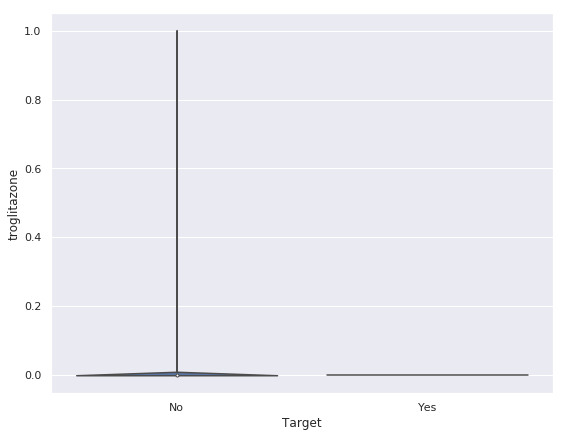

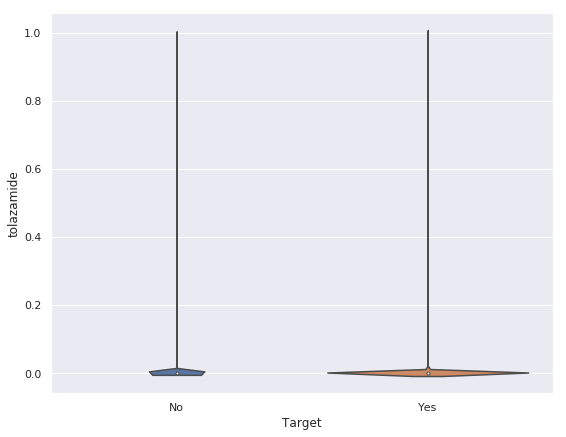

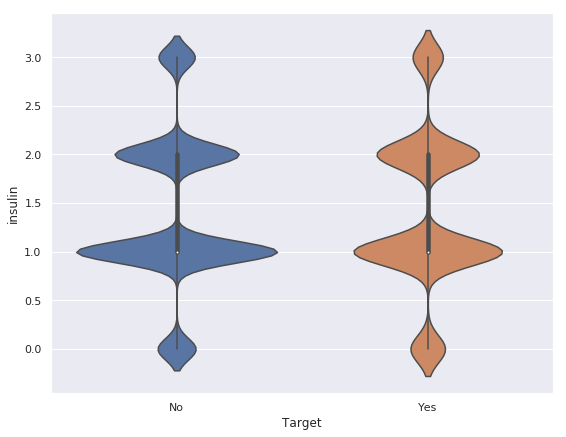

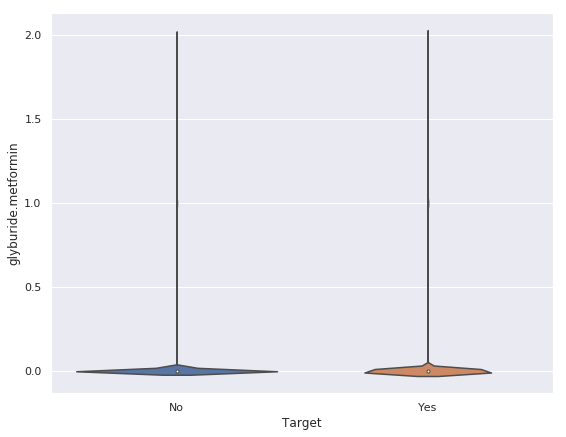

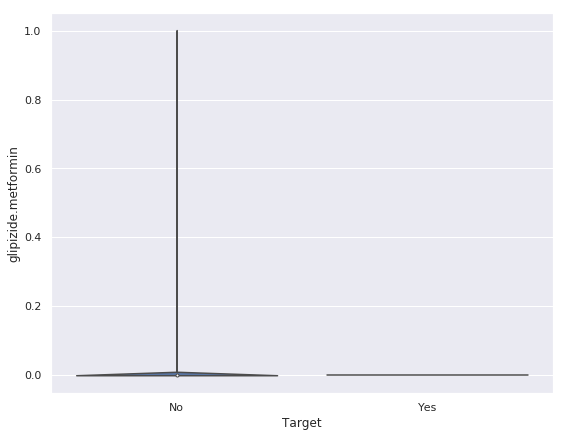

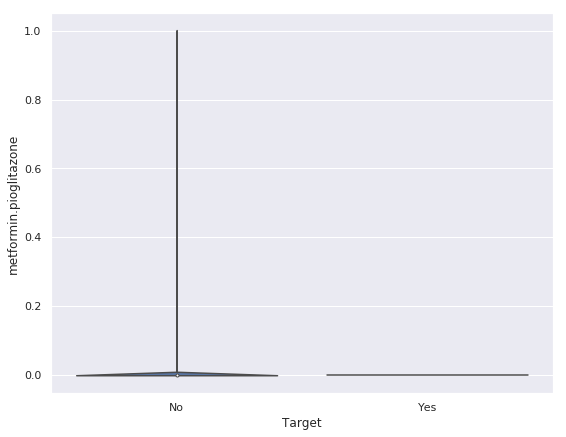

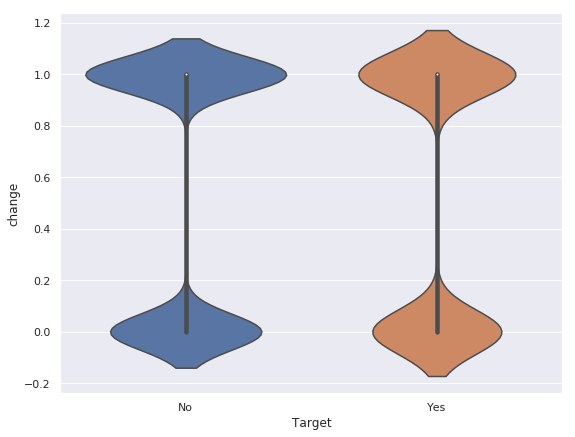

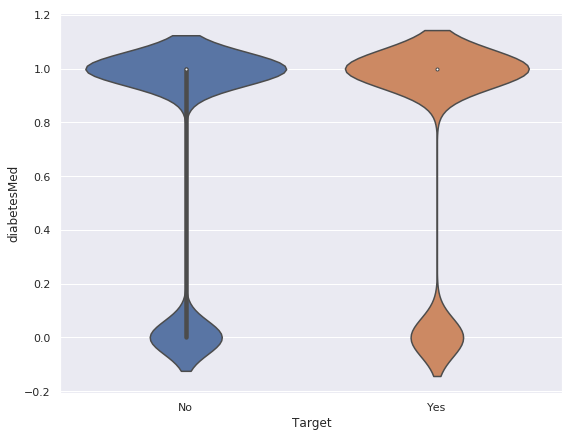

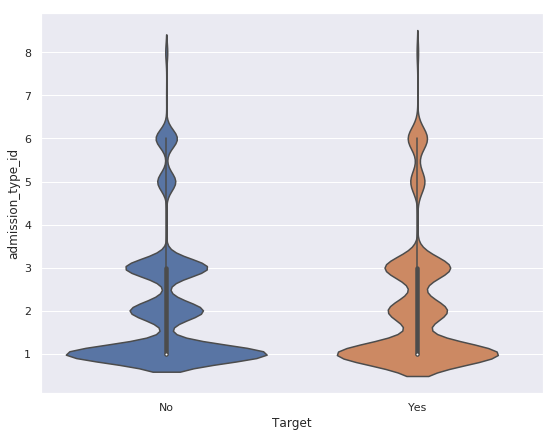

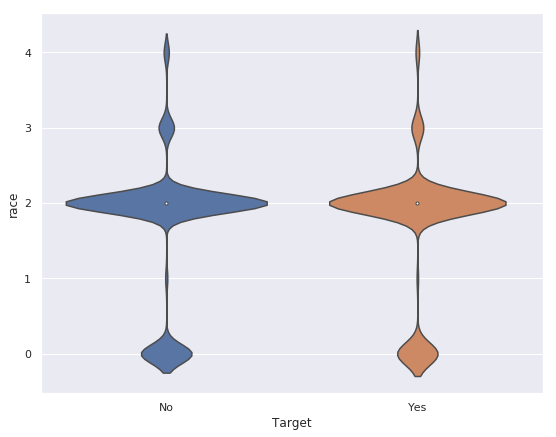

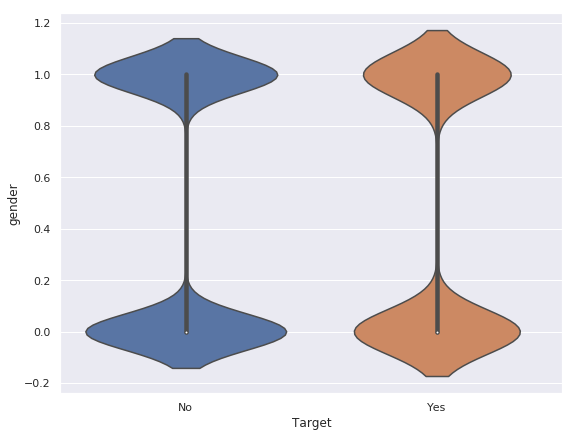

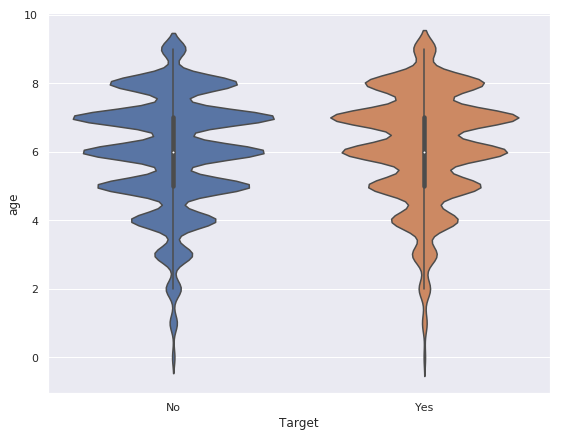

In [21]:
# ordinal:
for y in numerical_categorical[:-1]:
    plt.figure(figsize=(9,7))
    sns.violinplot(x=all_features.Target, y=y, data=all_features)
    plt.xlabel('Target', fontsize=12)
    plt.ylabel(y, fontsize=12)
    plt.show();

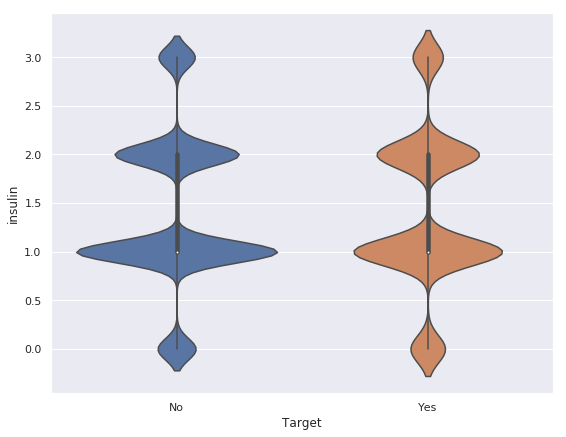

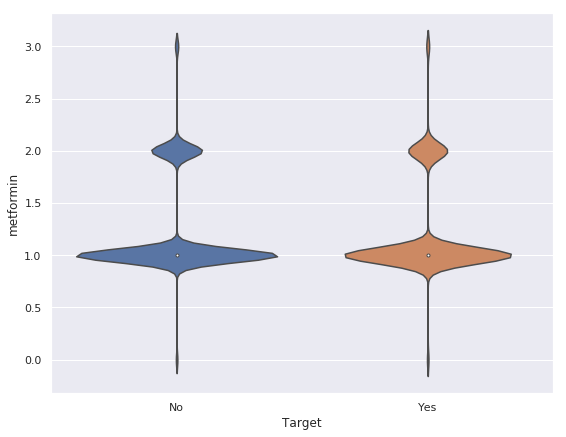

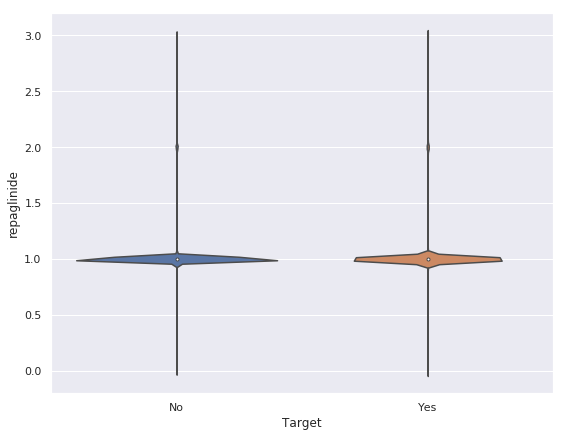

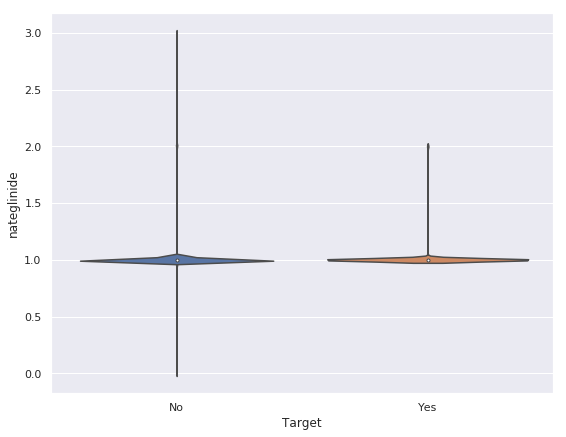

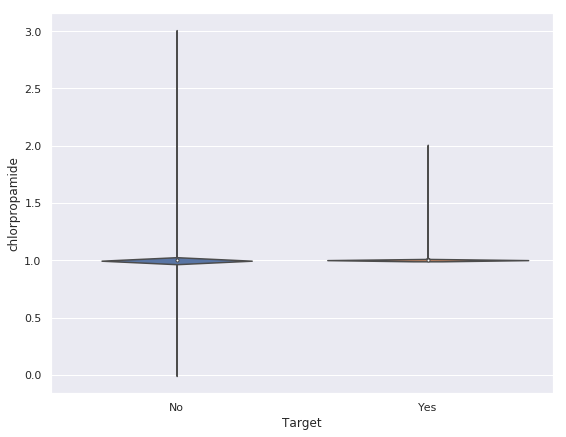

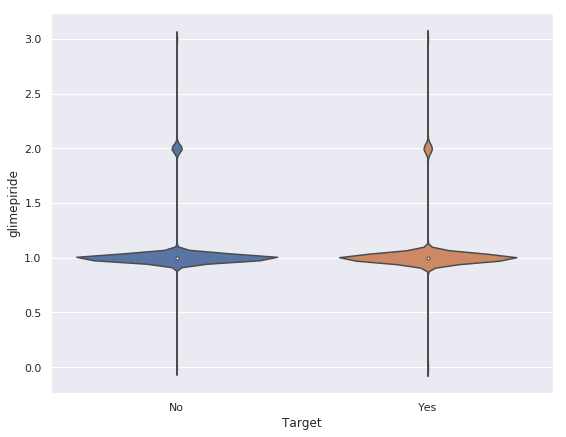

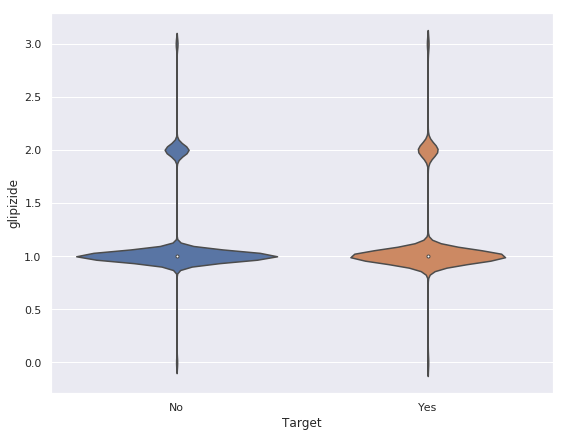

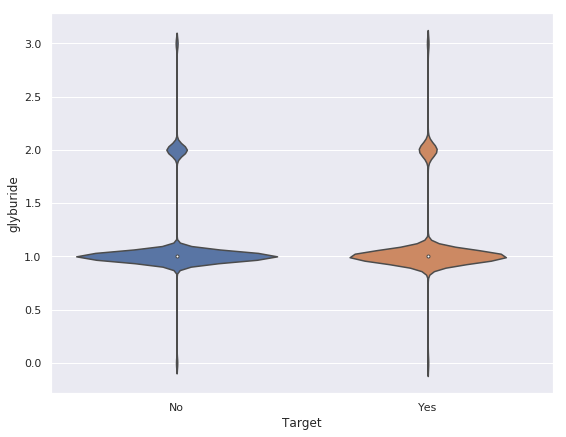

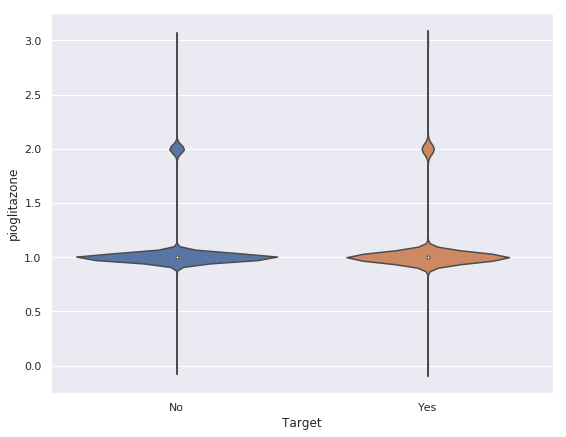

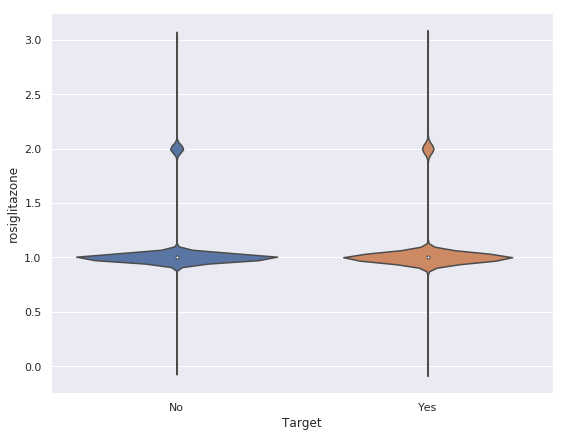

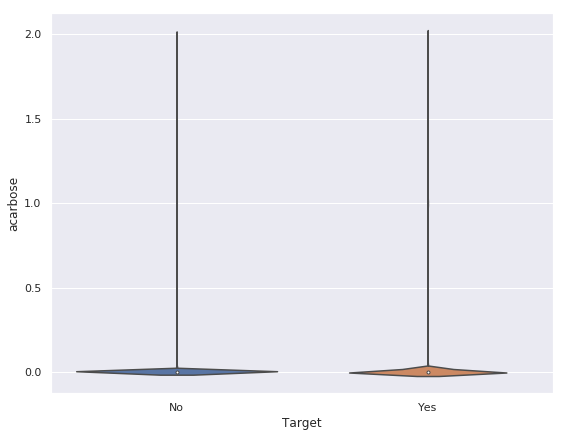

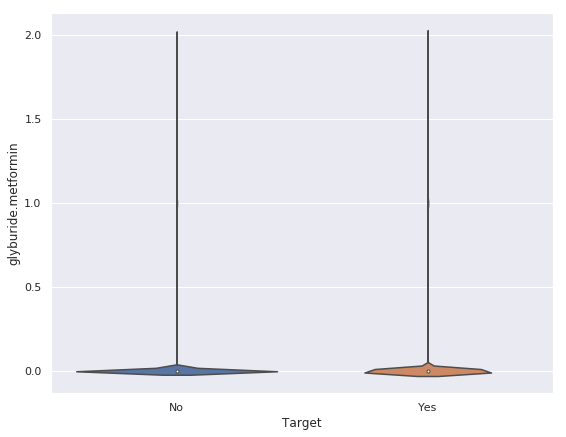

In [22]:
for y in ordinal:
    plt.figure(figsize=(9,7))
    sns.violinplot(x=all_features.Target, y=y, data=all_features)
    plt.xlabel('Target', fontsize=12)
    plt.ylabel(y, fontsize=12)
    plt.show();

In [23]:
# based on plots these features can be removed
all_features = all_features.drop(columns=['repaglinide', 'nateglinide', 'chlorpropamide'])

In [24]:
all_train_features = all_features[all_features['istrain']==1]
all_test_features = all_features[all_features['istrain']==0]
all_train_features = all_train_features.drop(columns='istrain')
all_test_features = all_test_features.drop(columns='istrain')

No     17786
Yes     6470
Name: Target, dtype: int64
No: 17786
Yes 6470
Proportion: 2.75 : 1
Random over-sampling:
Yes    17786
No     17786
Name: Target, dtype: int64


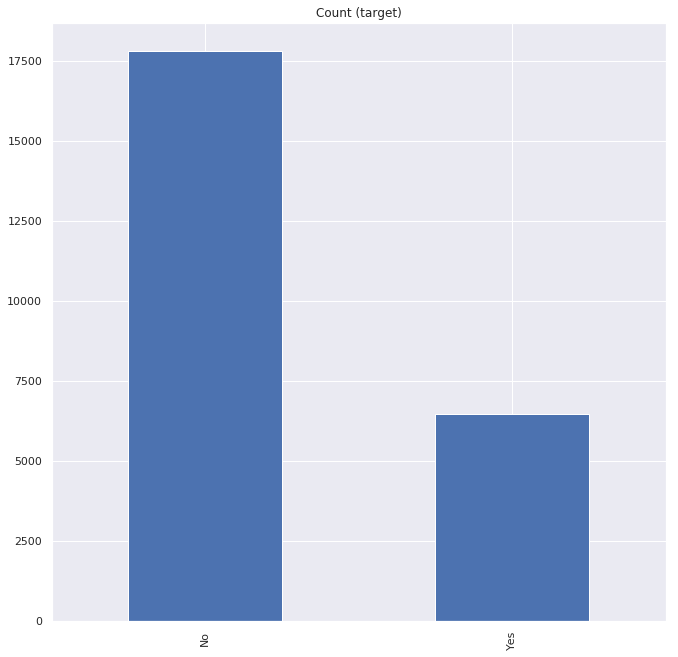

In [25]:
# target imbalance
t = all_train_features

target_count = t['Target'].value_counts()
print(target_count)
print('No:', target_count[0])
print('Yes', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)');

# Sampling for target imbalance:
# Class count
# count_class_0 = No; count_class_1 = Yes
count_class_0, count_class_1 = all_features['Target'].value_counts()

# Divide by class
df_class_0 = all_features[all_features['Target'] == 'No']
df_class_1 = all_features[all_features['Target'] == 'Yes']

# Random Over-sampling:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over.Target.value_counts())

In [26]:
# Encode Target Feature
lb = LabelBinarizer()
all_train_features['Target'] = lb.fit_transform(all_train_features['Target'])

In [27]:
# all_train_data.columns
X = all_train_features.drop(columns=['patientID','Target'])
y = all_train_features['Target']

all_test_features = all_test_features.drop(columns='Target')

In [28]:
def plot_roc_curve(fpr, tpr):  
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

AUC: 0.53


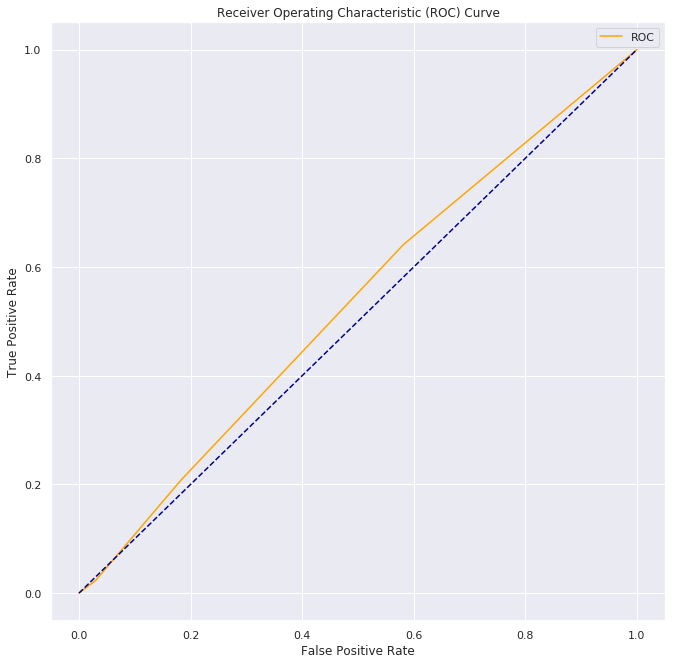

/home/divyanallamalli/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


AUC: 0.52


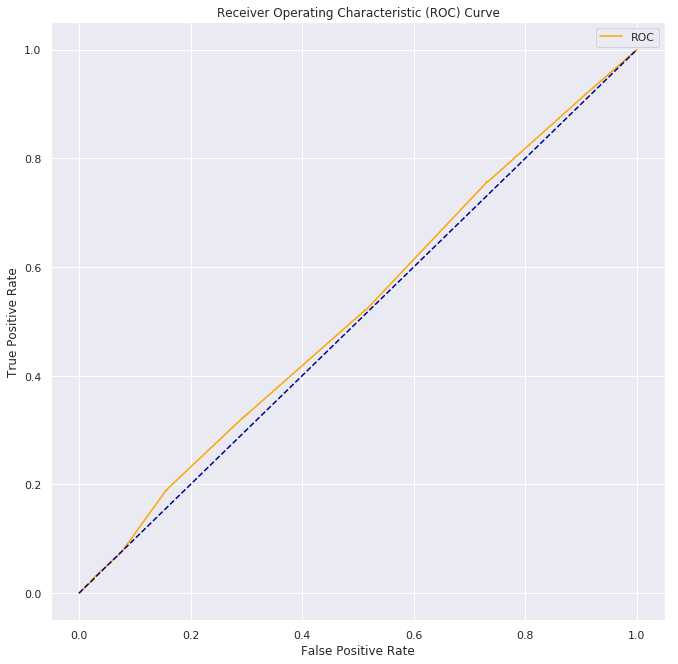

AUC: 0.54


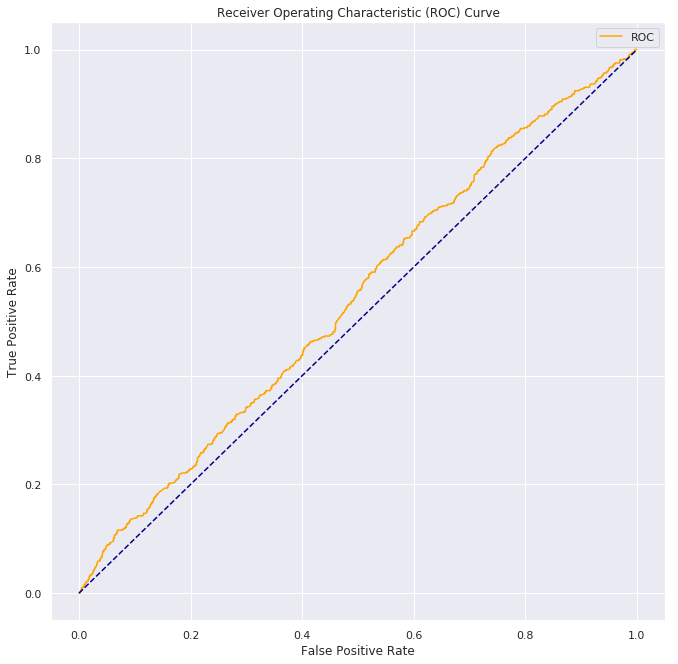

AUC: 0.55


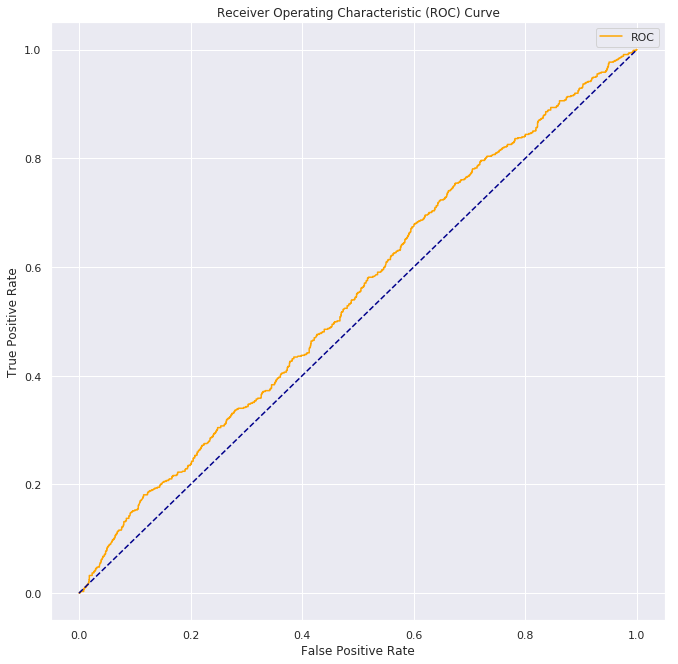

AUC: 0.53


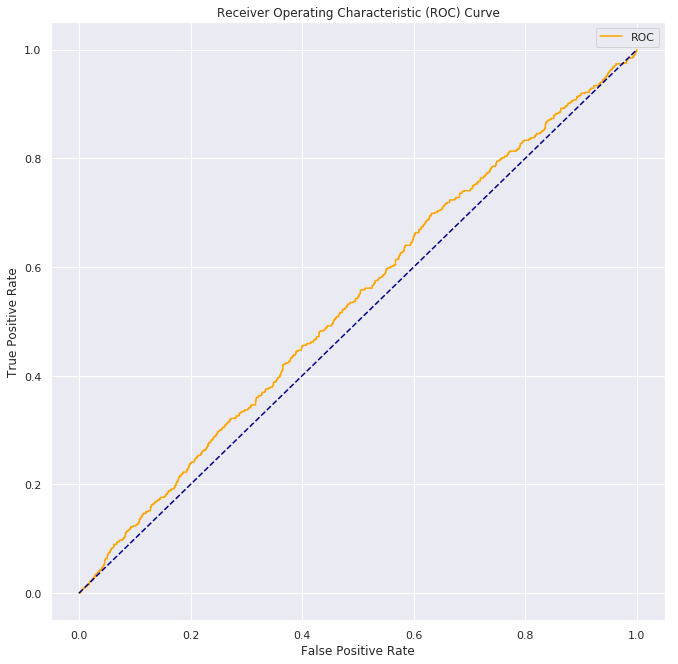

/home/divyanallamalli/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUC: 0.54


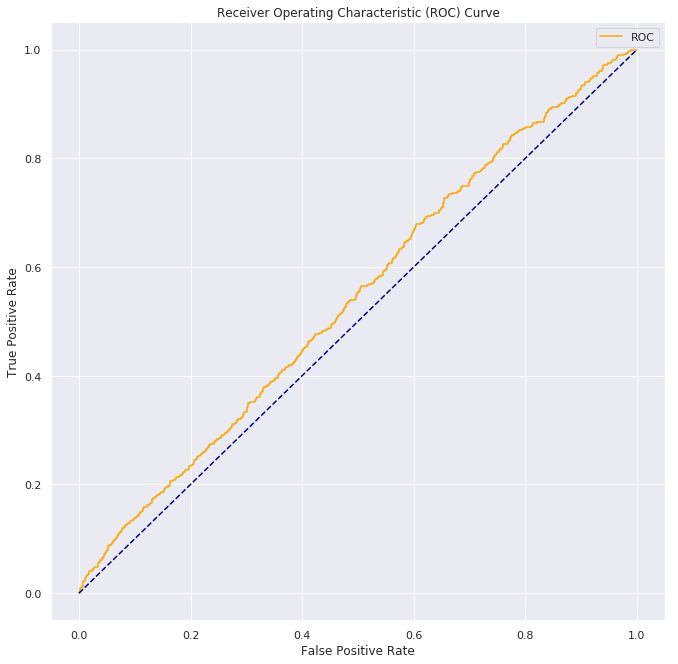

AUC: 0.51


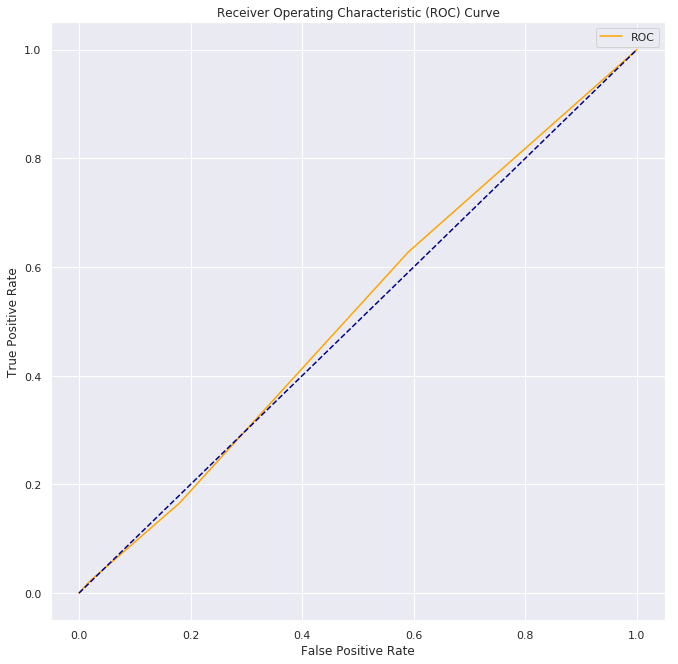

AUC: 0.51


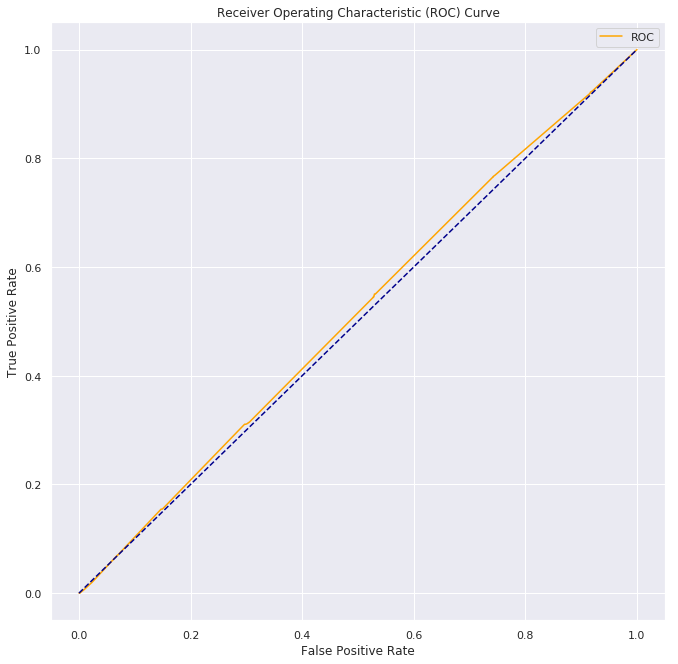

AUC: 0.54


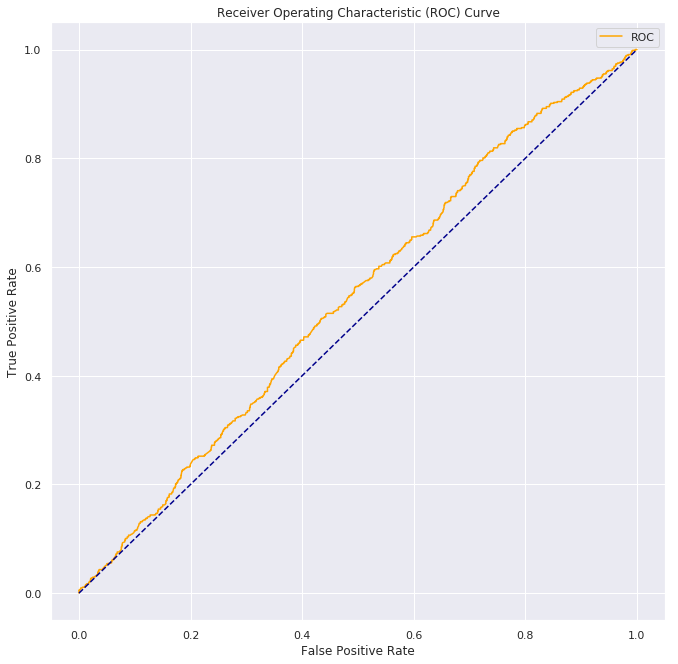

AUC: 0.55


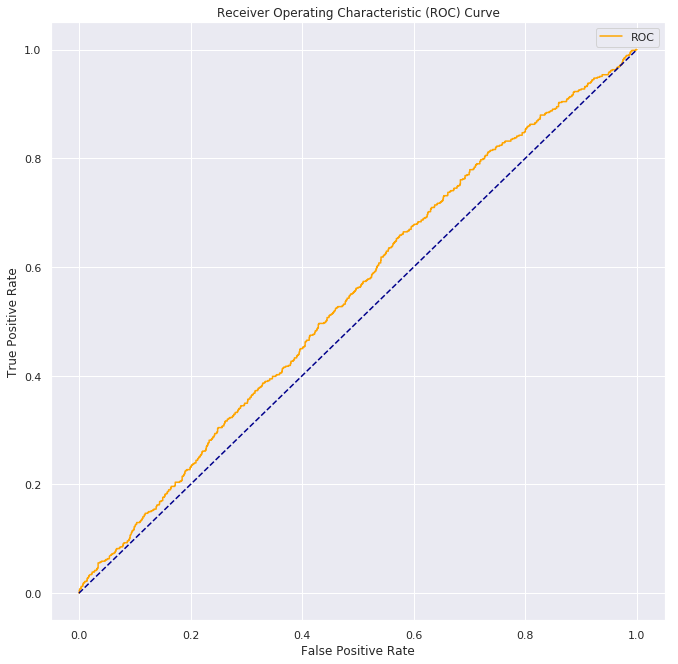

AUC: 0.55


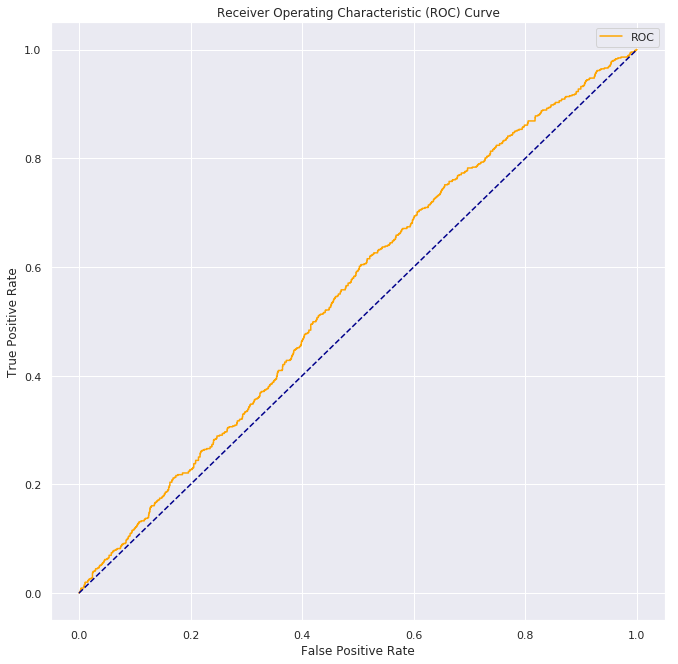

/home/divyanallamalli/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUC: 0.55


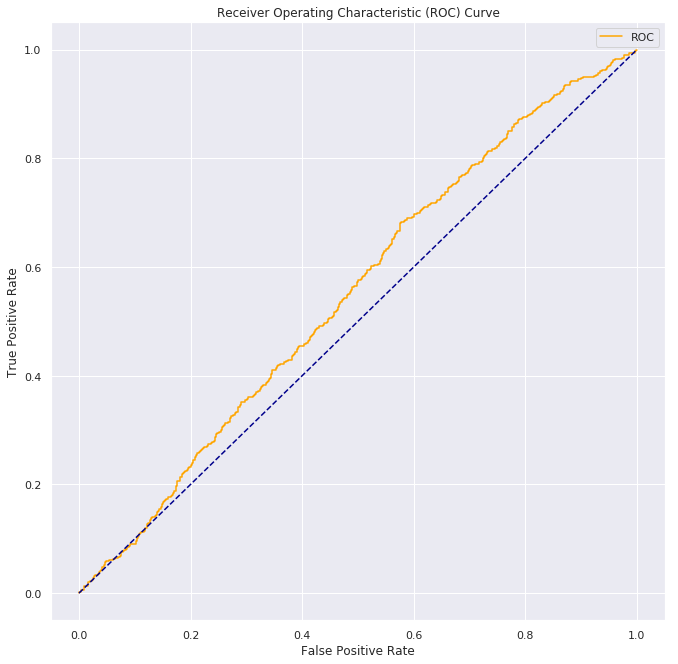

AUC: 0.49


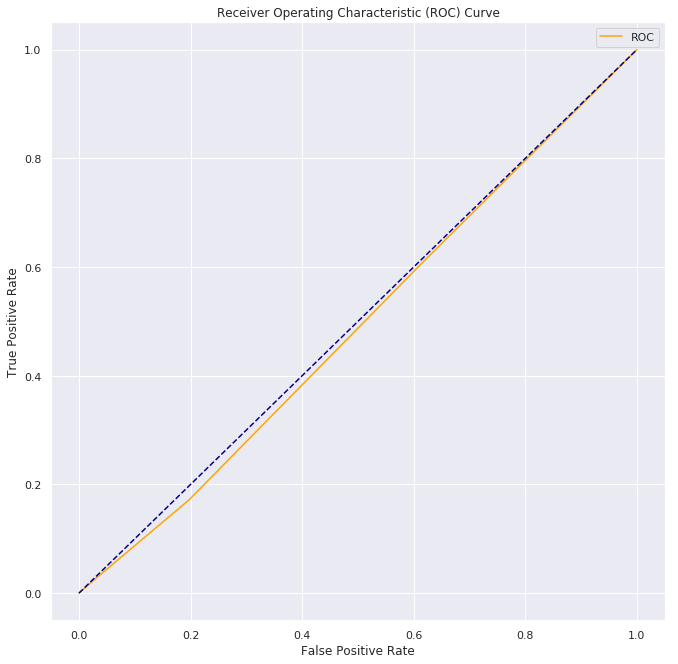

AUC: 0.53


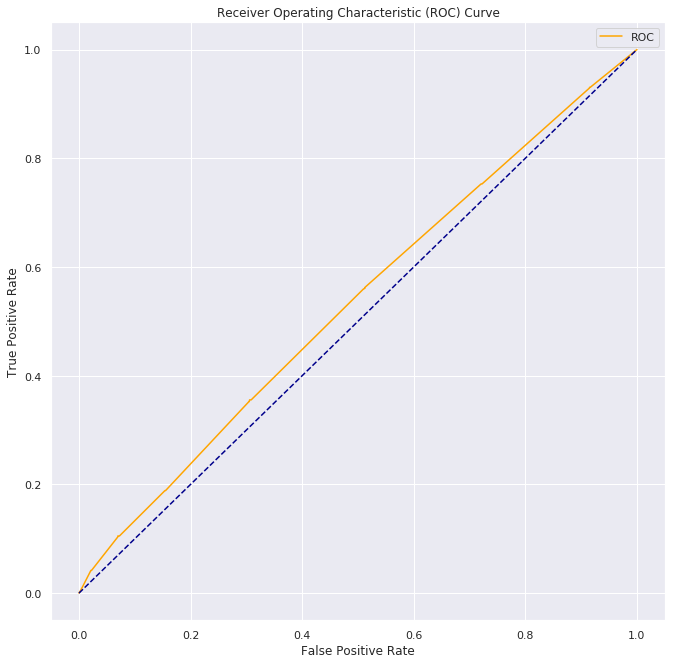

AUC: 0.56


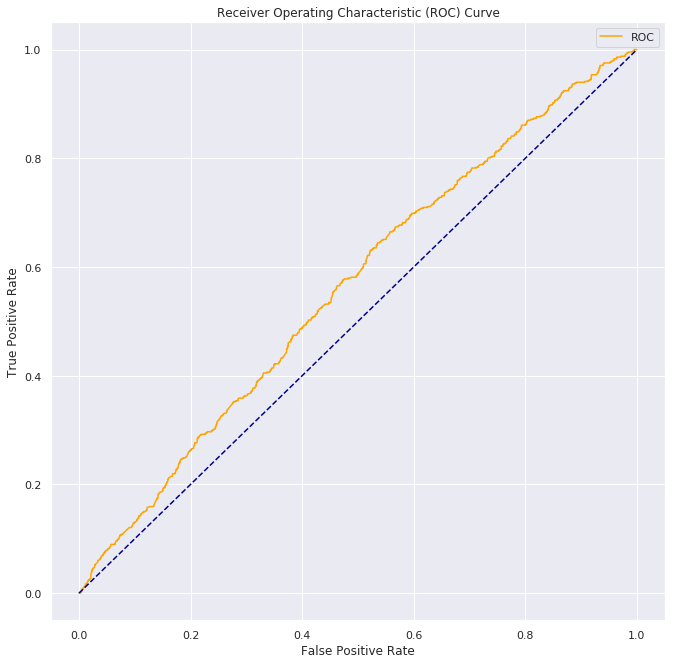

AUC: 0.57


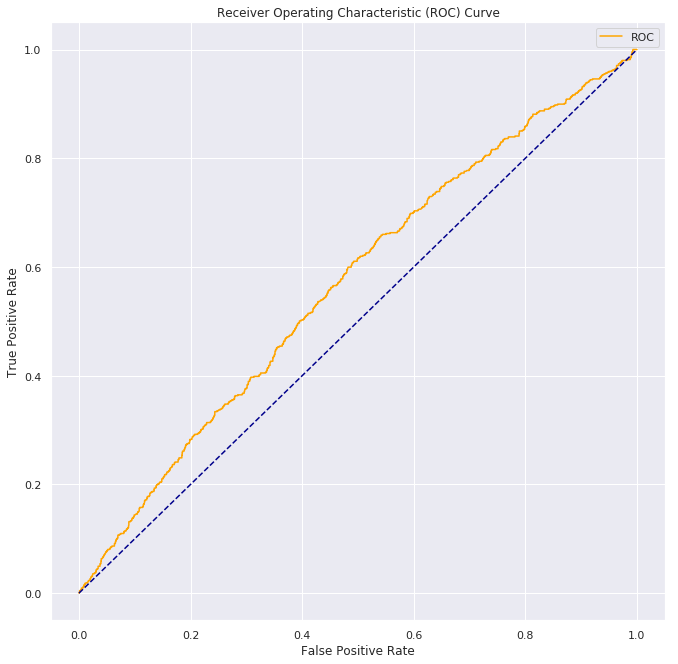

AUC: 0.56


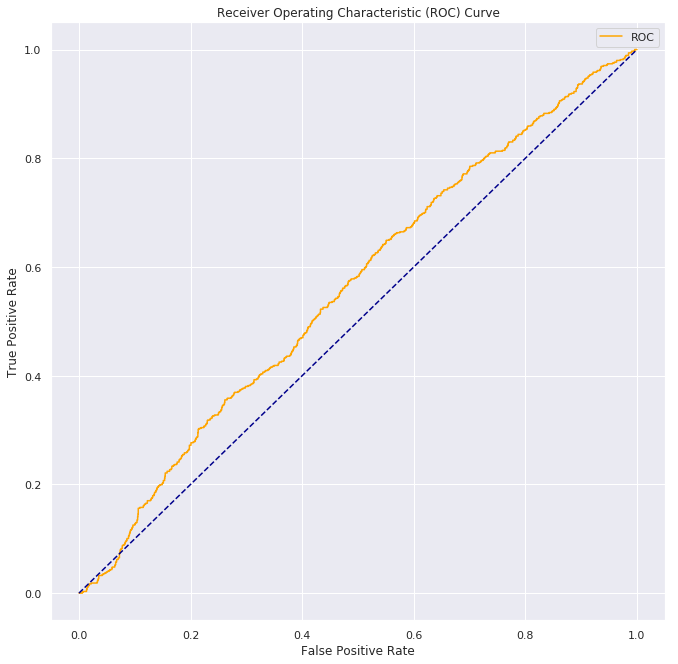

/home/divyanallamalli/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUC: 0.57


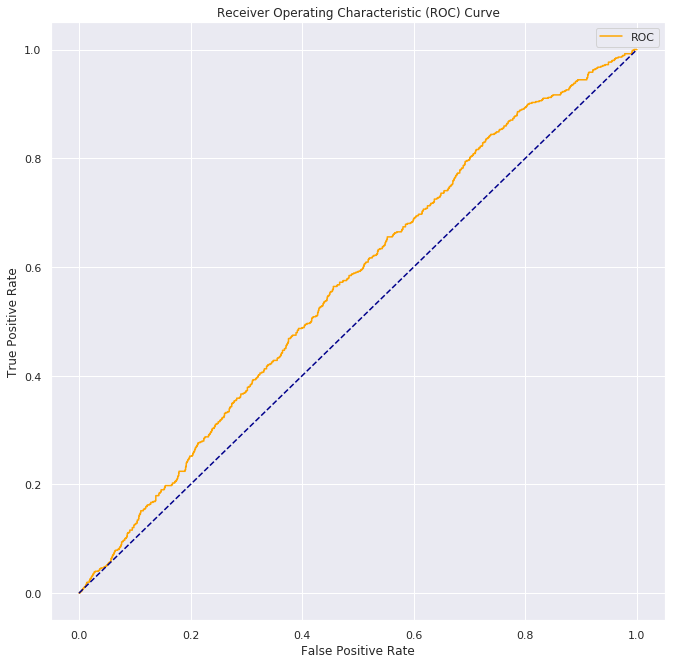

AUC: 0.53


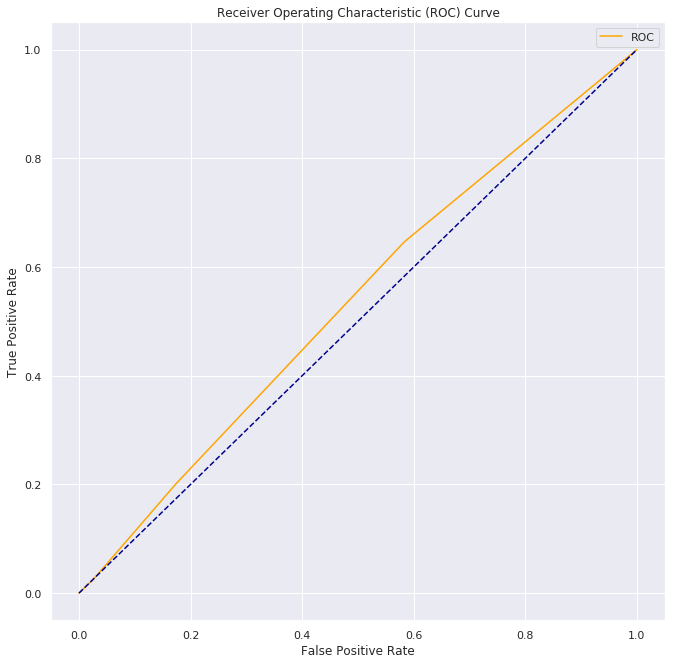

AUC: 0.53


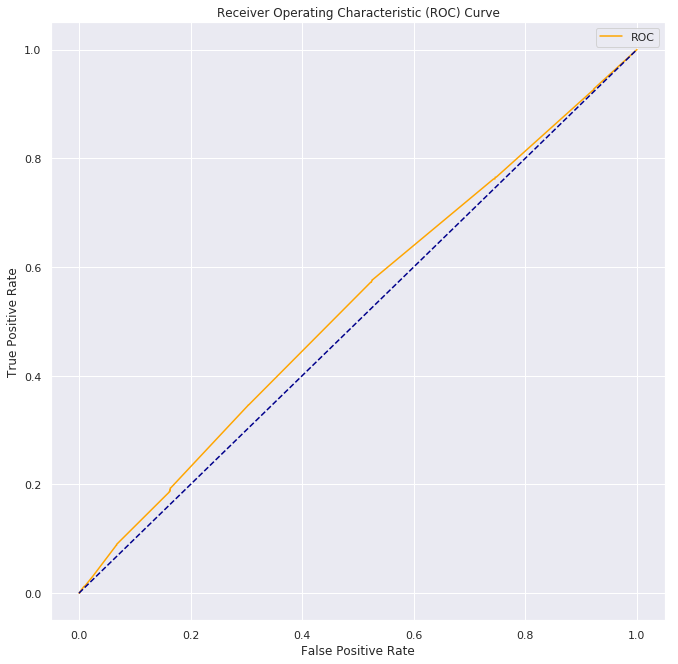

AUC: 0.54


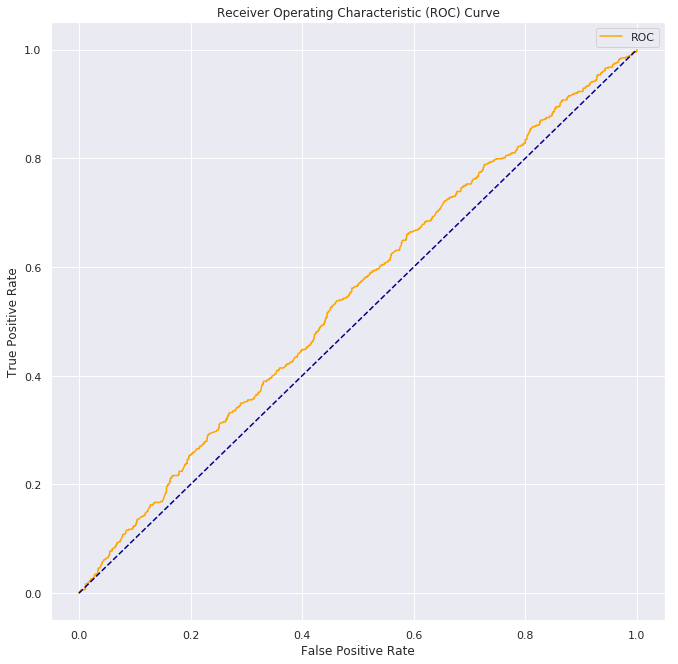

AUC: 0.55


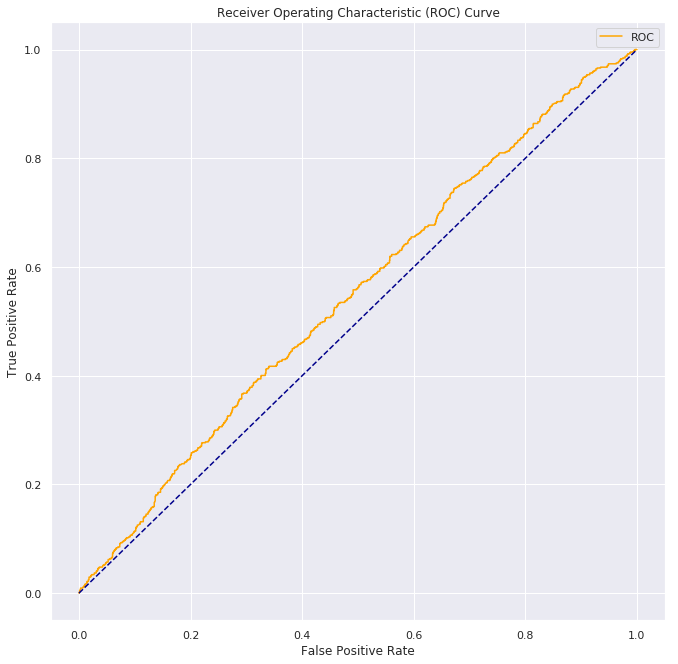

AUC: 0.54


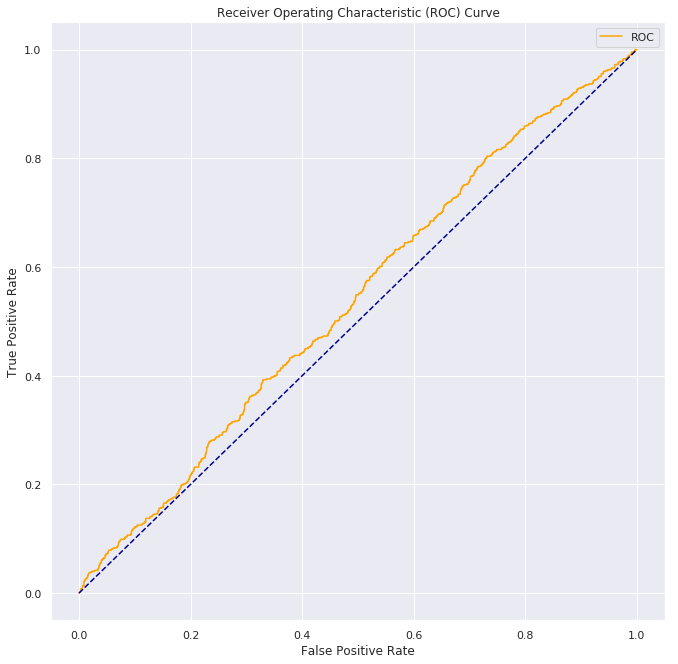

/home/divyanallamalli/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUC: 0.55


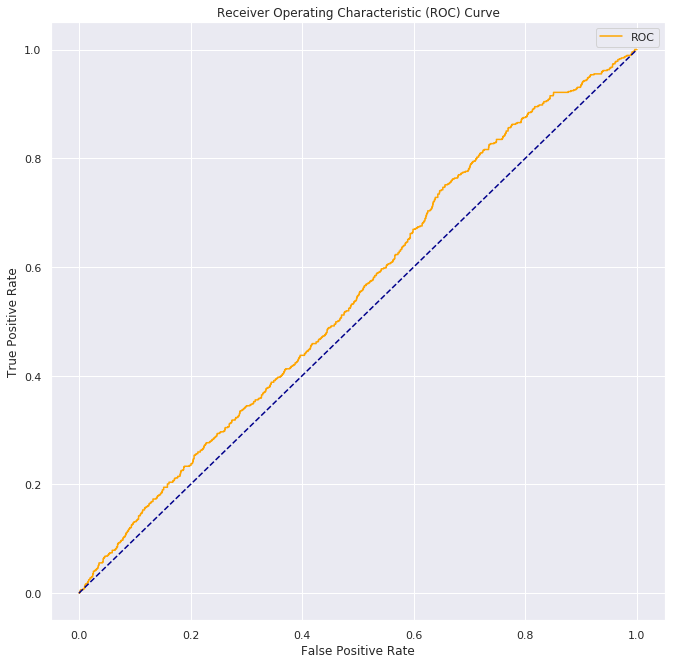

AUC: 0.49


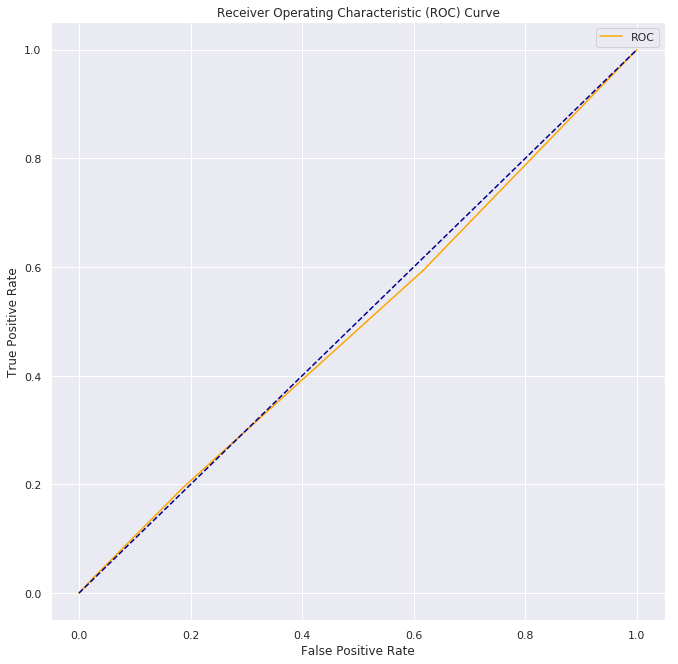

AUC: 0.51


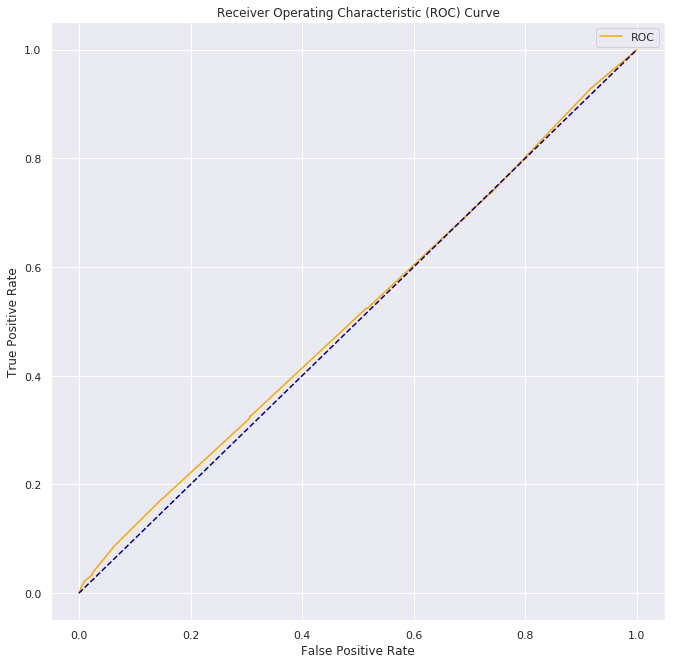

AUC: 0.54


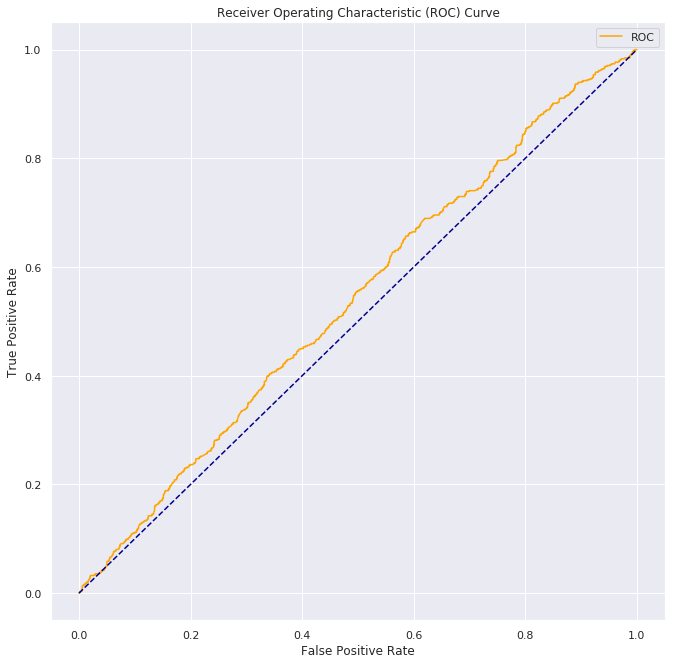

AUC: 0.53


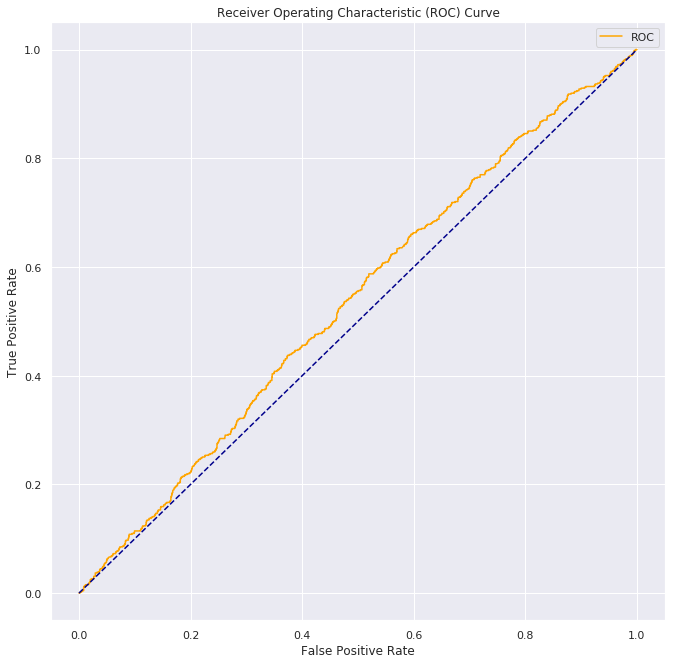

AUC: 0.53


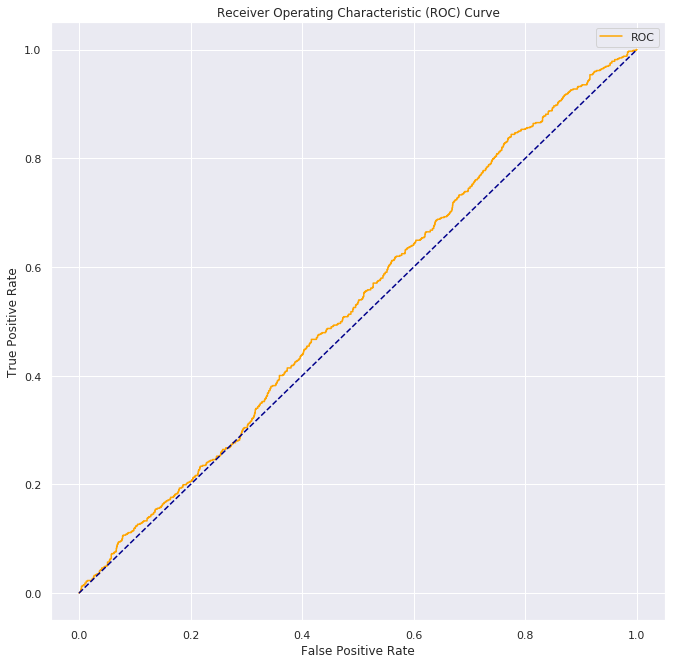

/home/divyanallamalli/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUC: 0.54


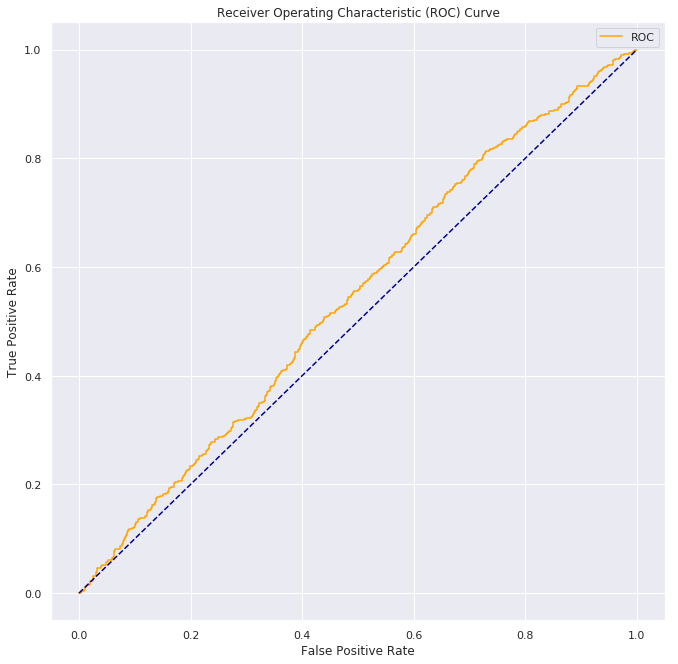

AUC: 0.52


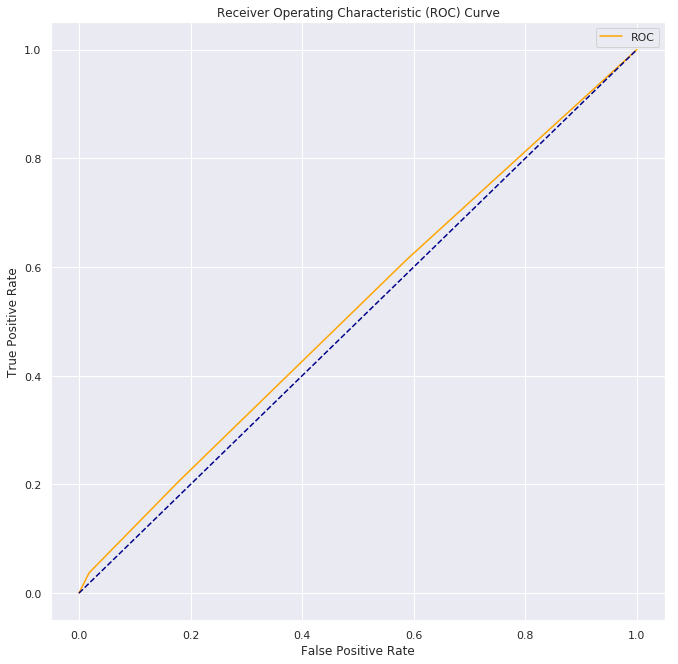

AUC: 0.52


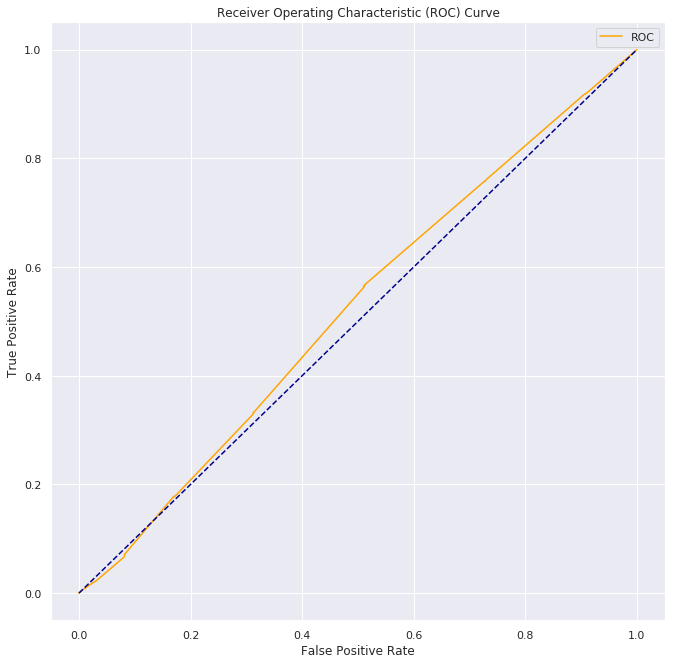

AUC: 0.54


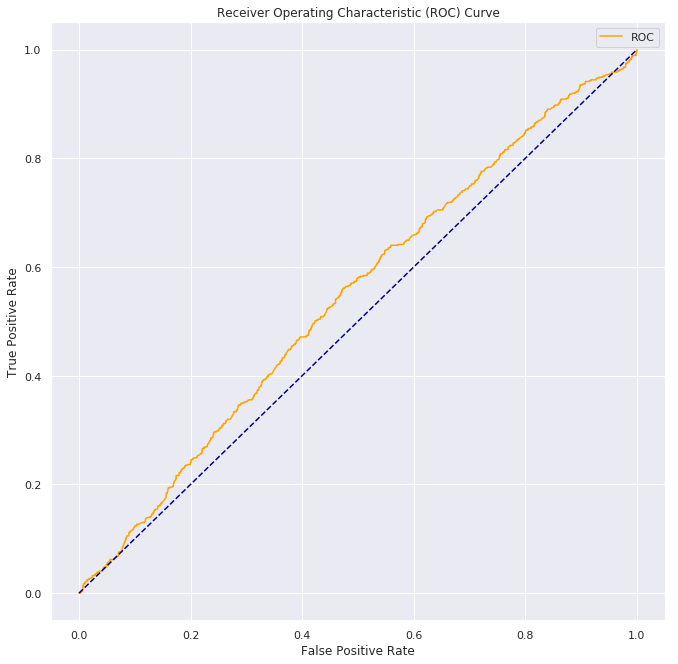

AUC: 0.54


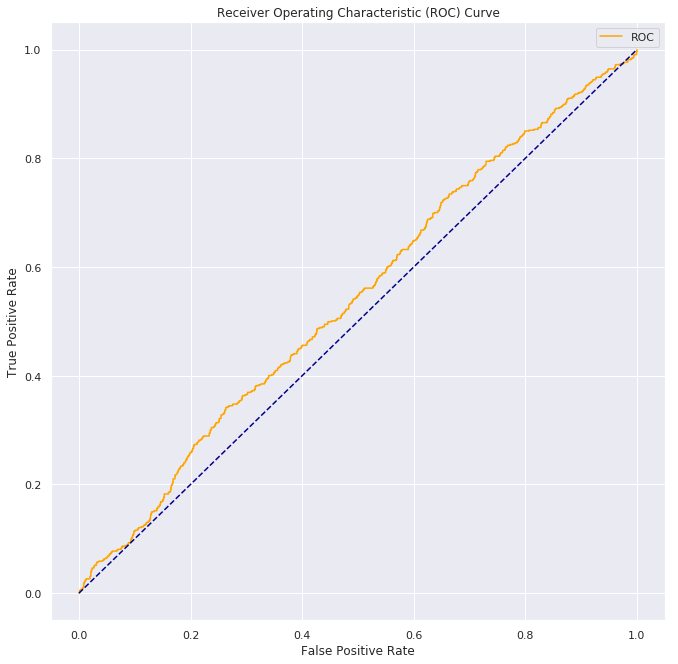

AUC: 0.54


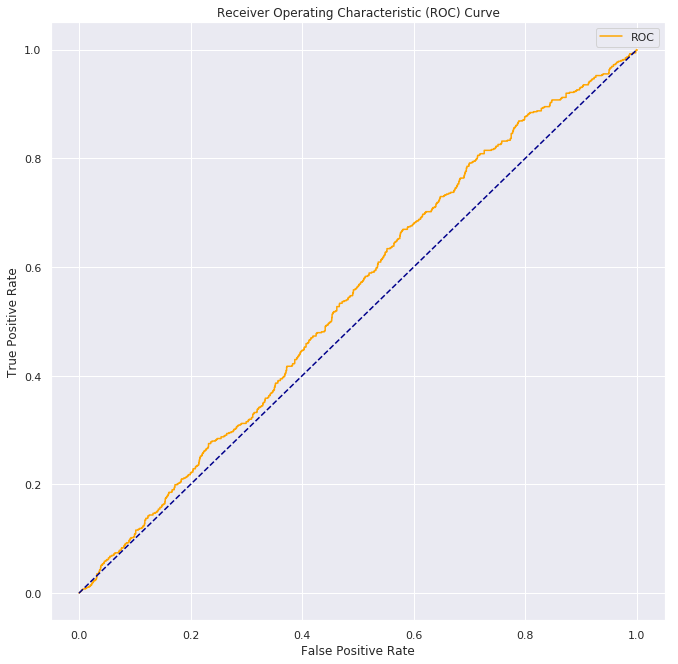

/home/divyanallamalli/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUC: 0.55


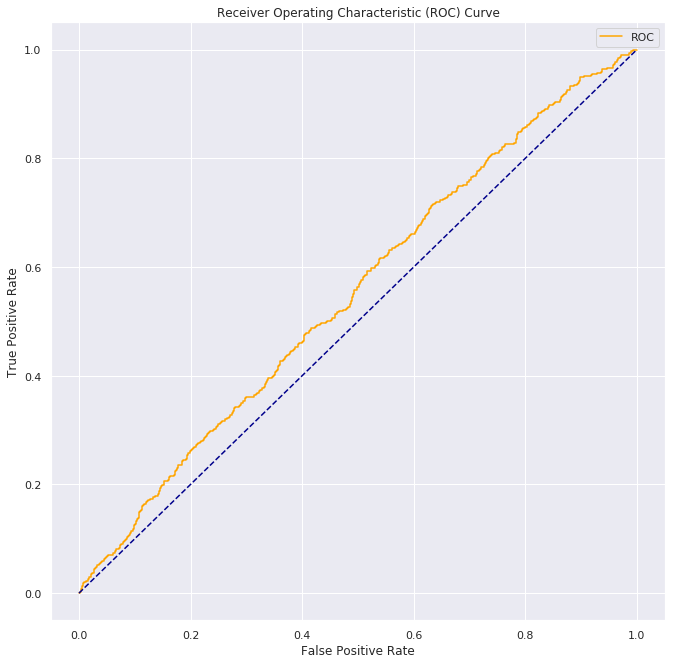

AUC: 0.50


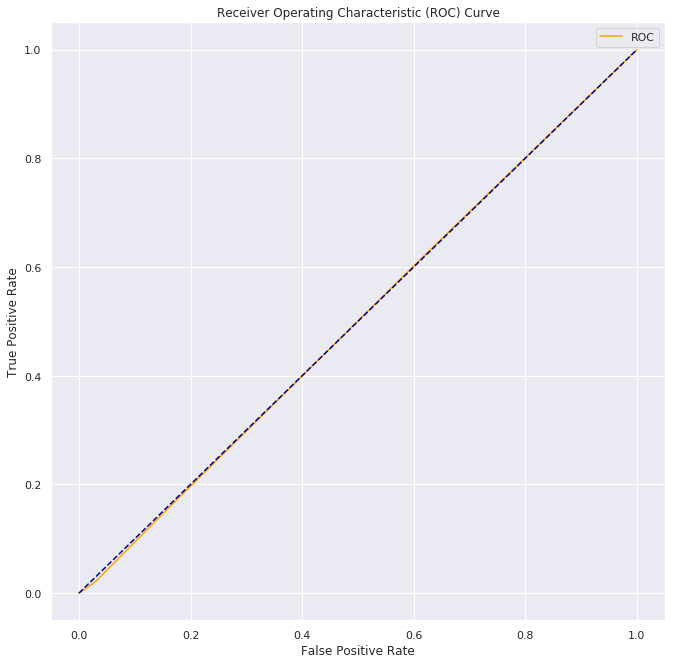

AUC: 0.52


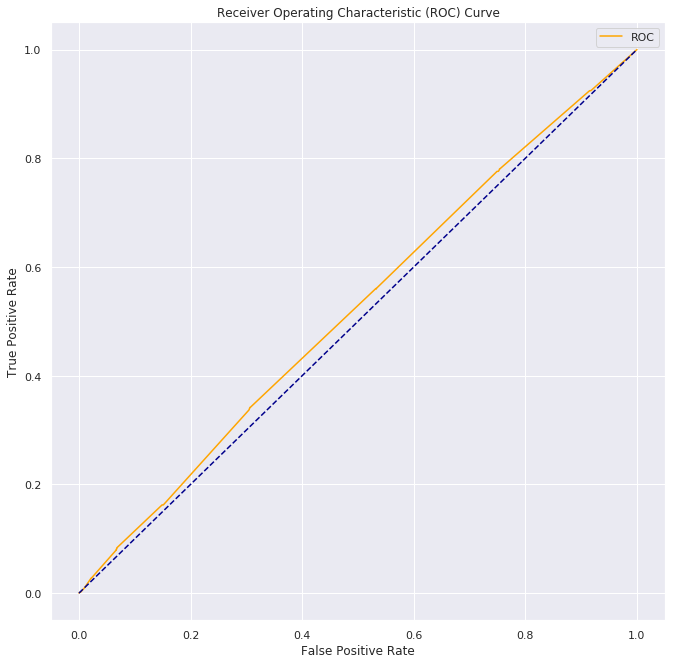

AUC: 0.57


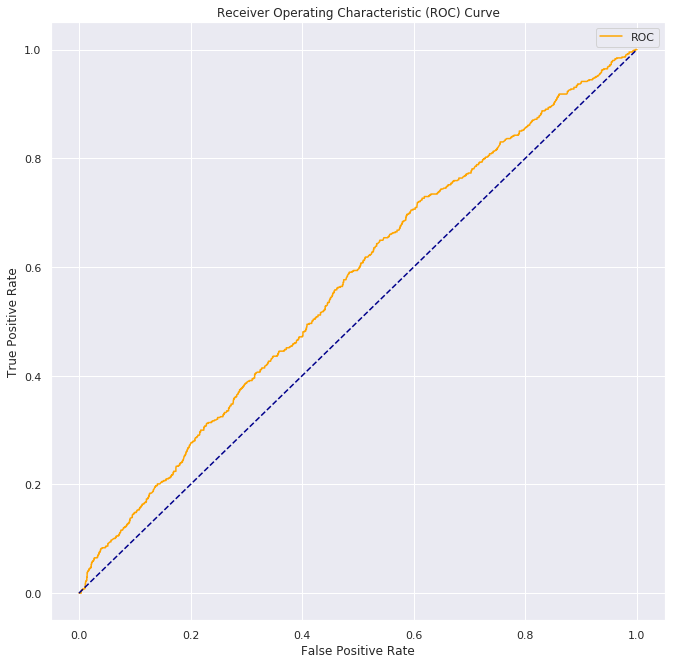

AUC: 0.57


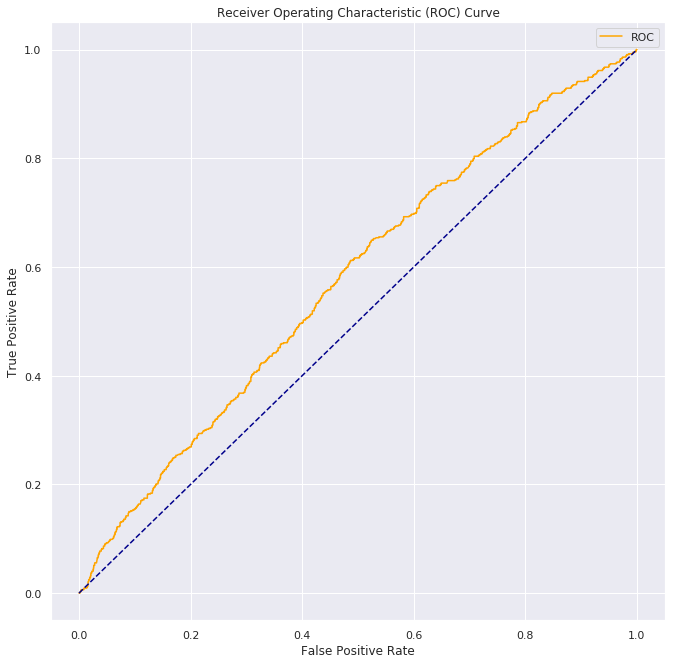

AUC: 0.57


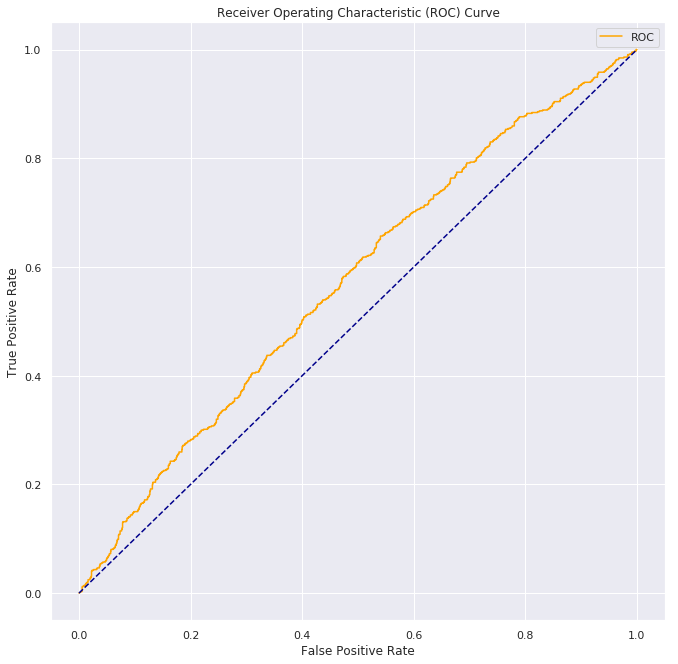

/home/divyanallamalli/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUC: 0.57


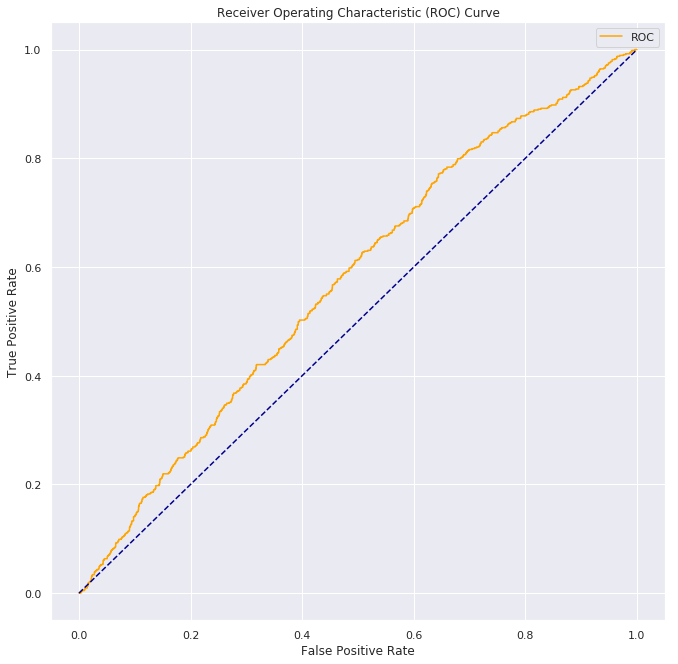

AUC: 0.51


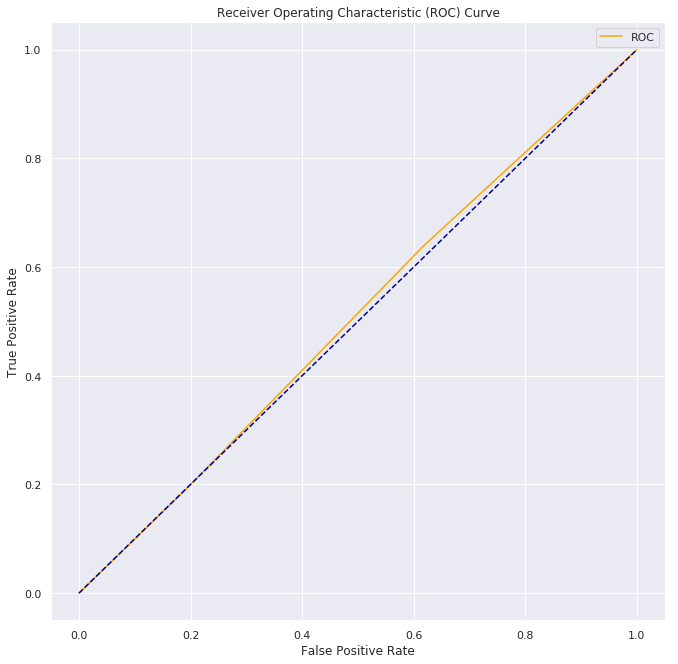

AUC: 0.54


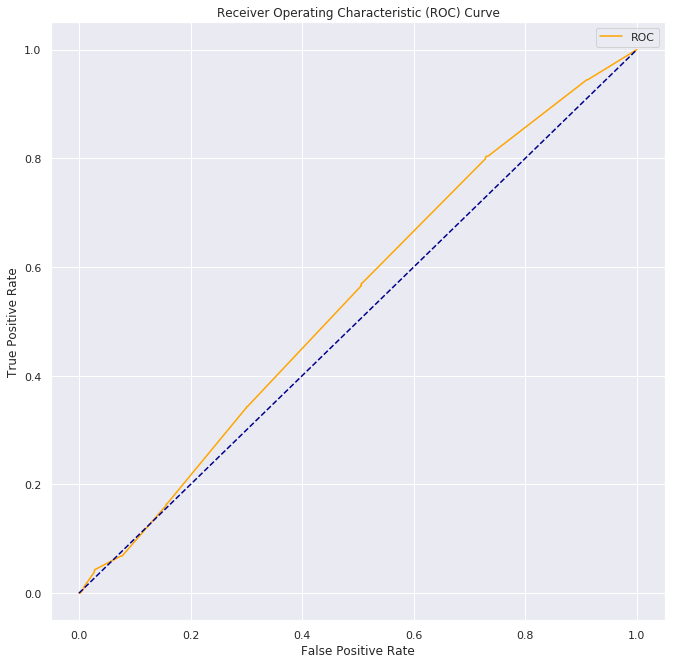

AUC: 0.56


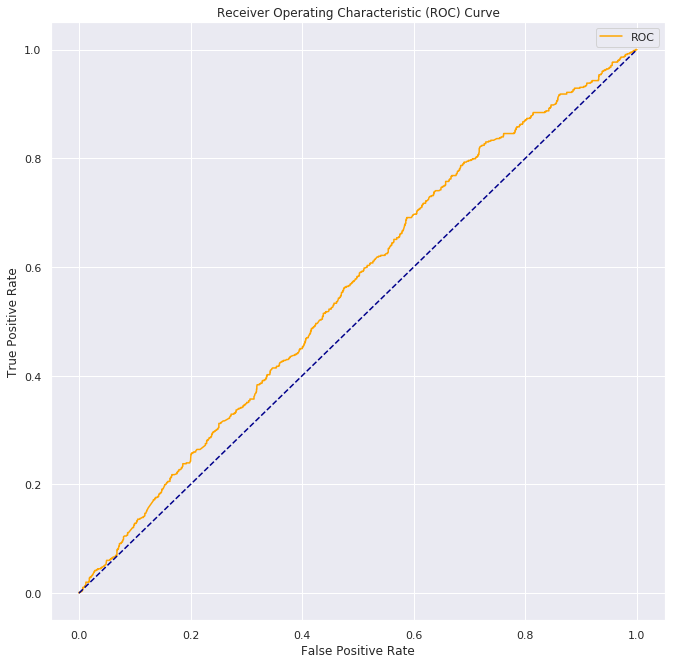

AUC: 0.56


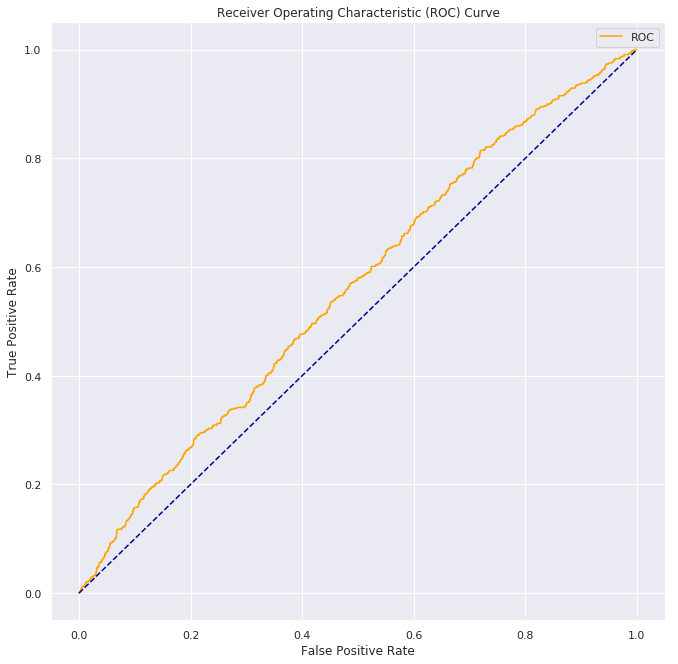

AUC: 0.54


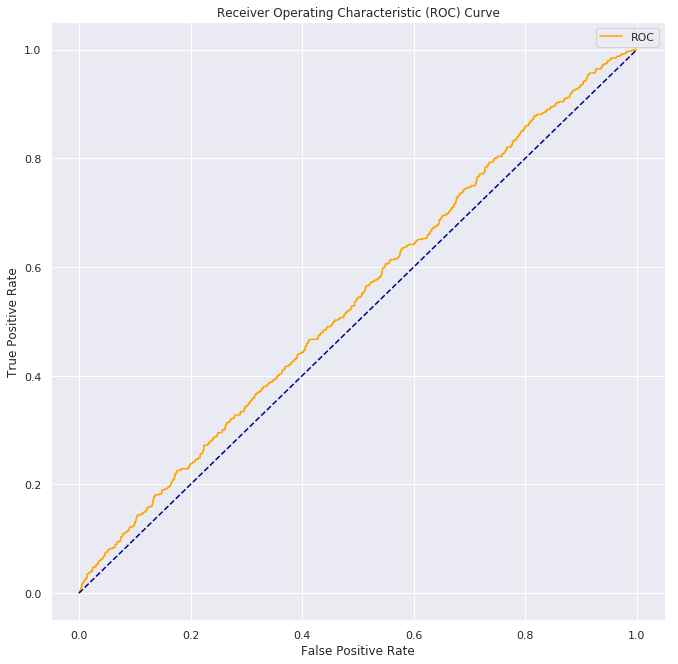

/home/divyanallamalli/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUC: 0.55


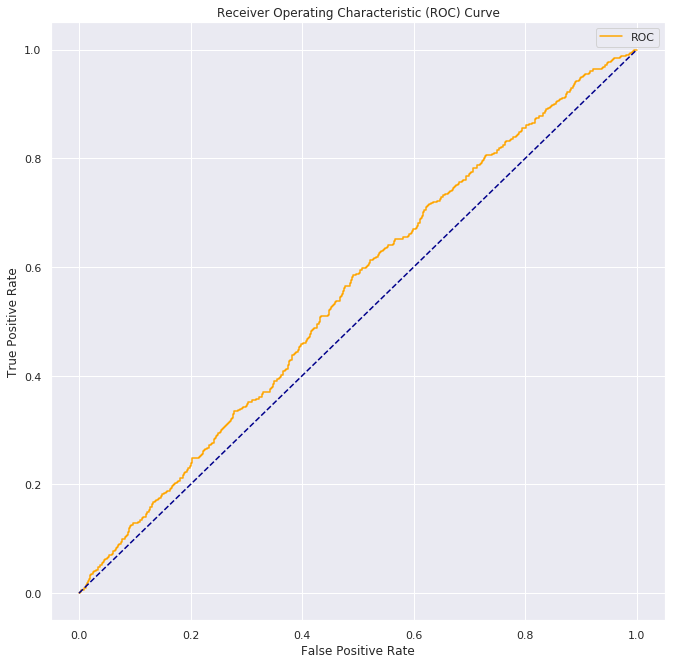

AUC: 0.52


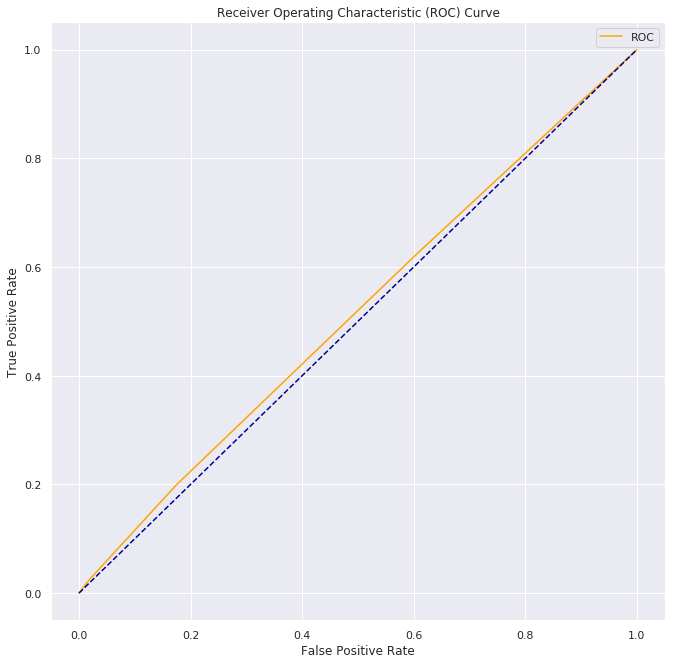

AUC: 0.51


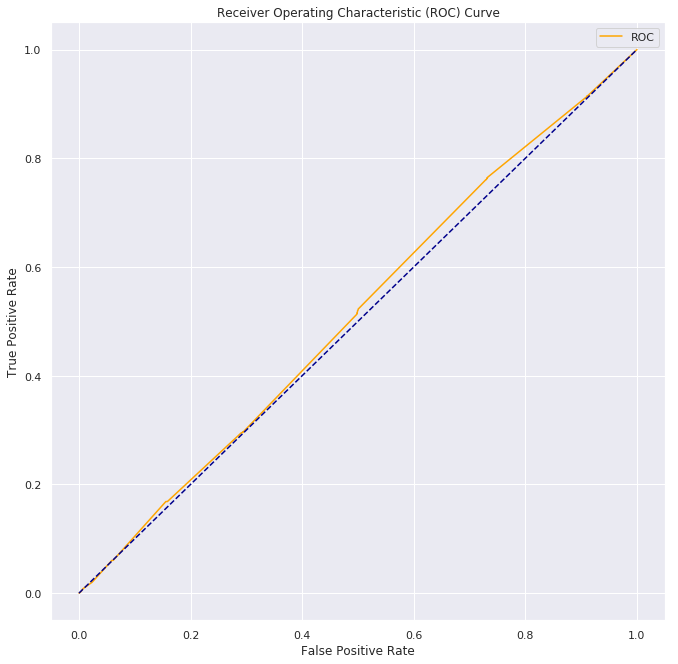

AUC: 0.54


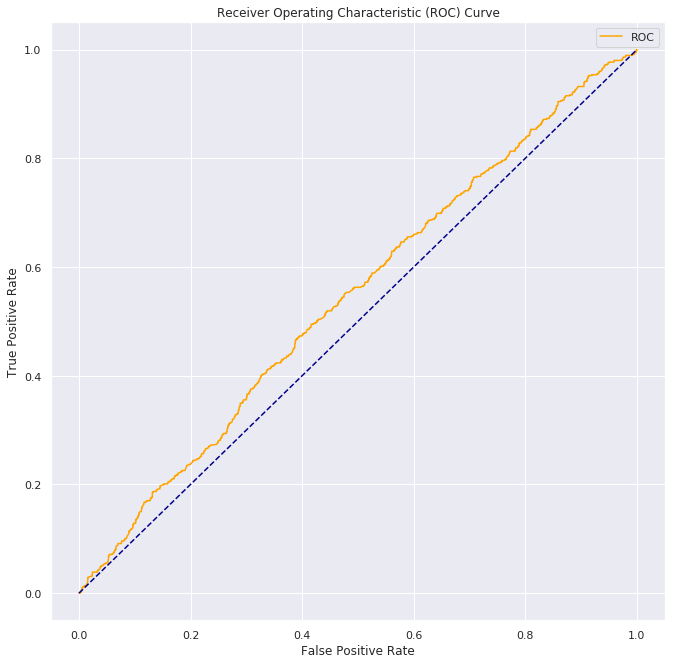

AUC: 0.55


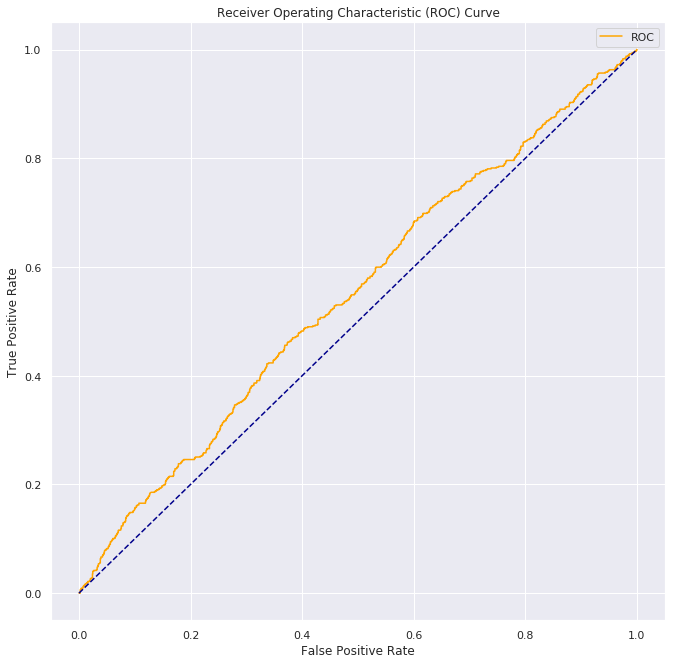

AUC: 0.54


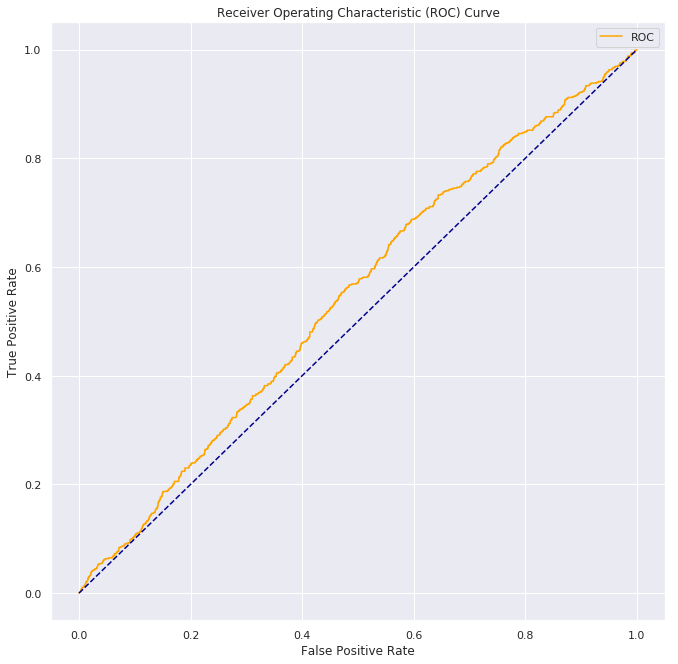

/home/divyanallamalli/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUC: 0.55


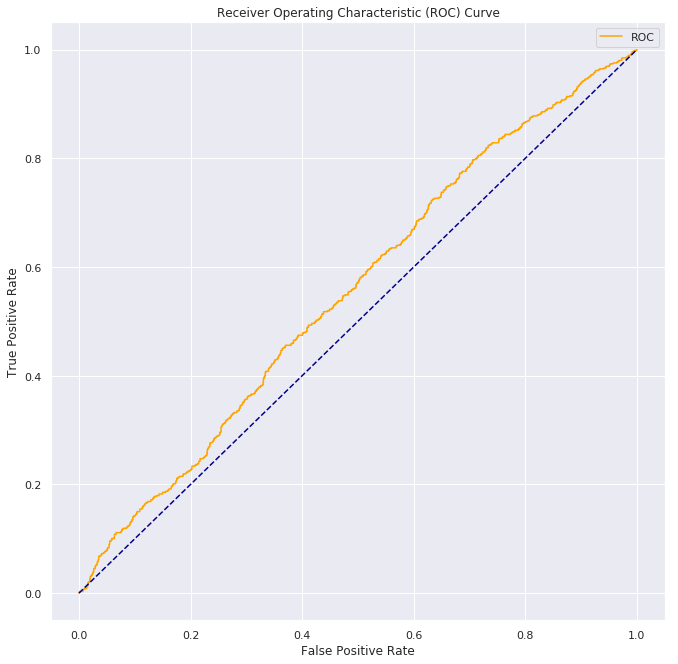

AUC: 0.51


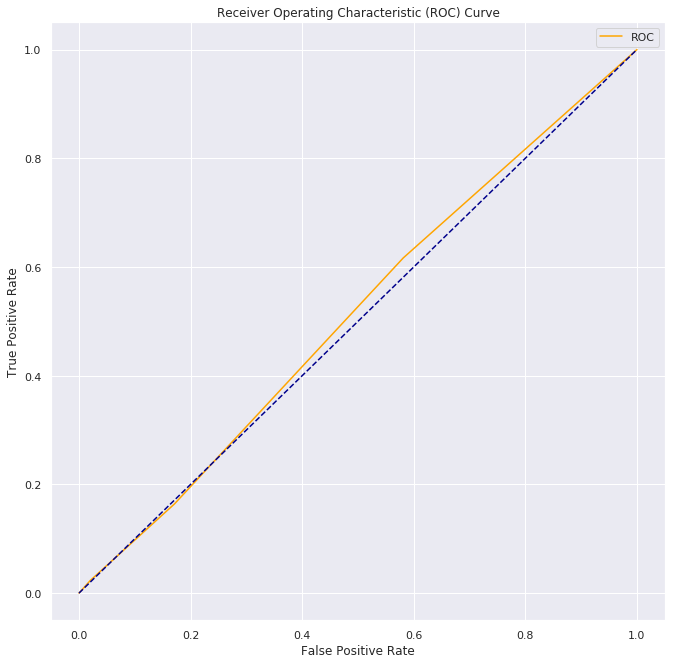

AUC: 0.52


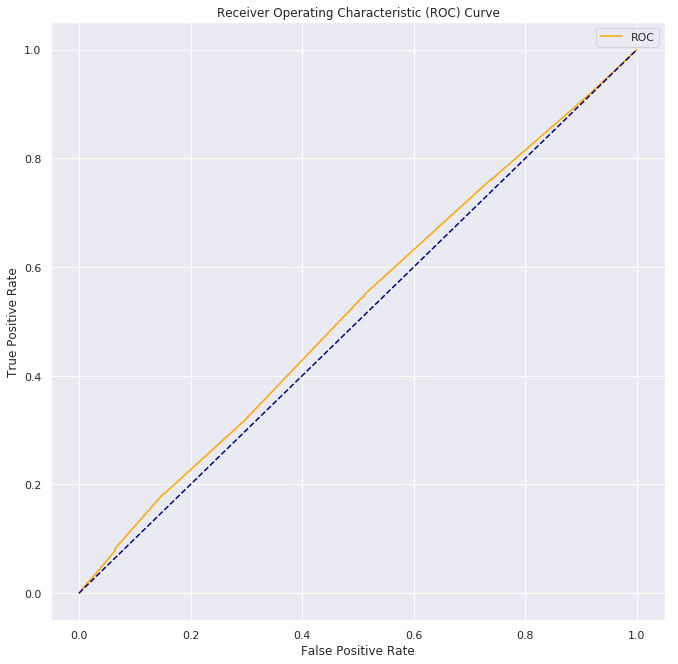

AUC: 0.54


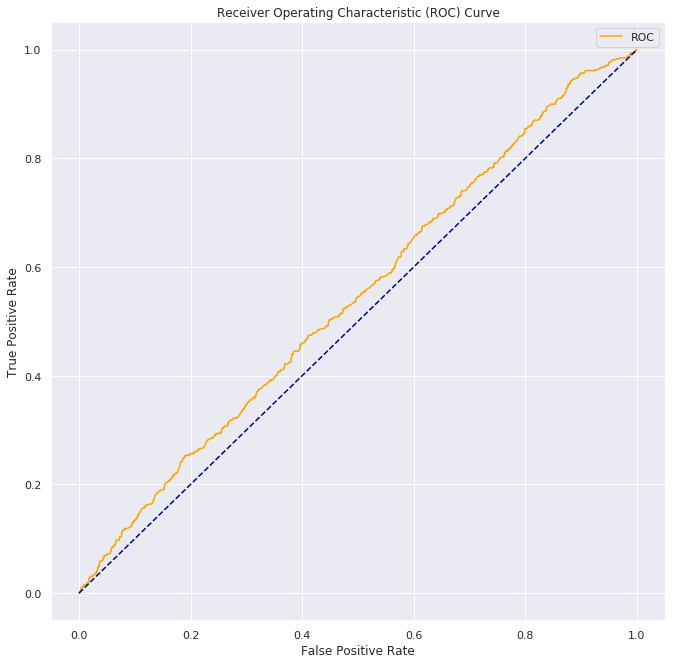

AUC: 0.54


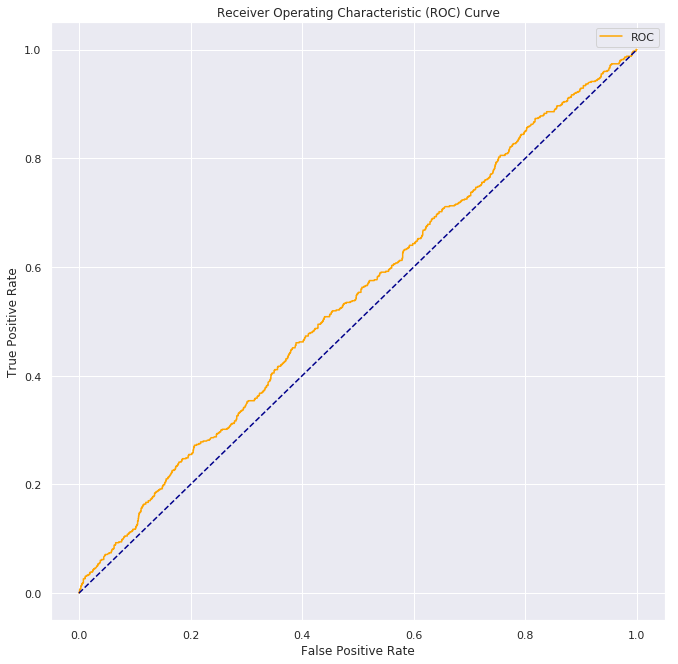

AUC: 0.53


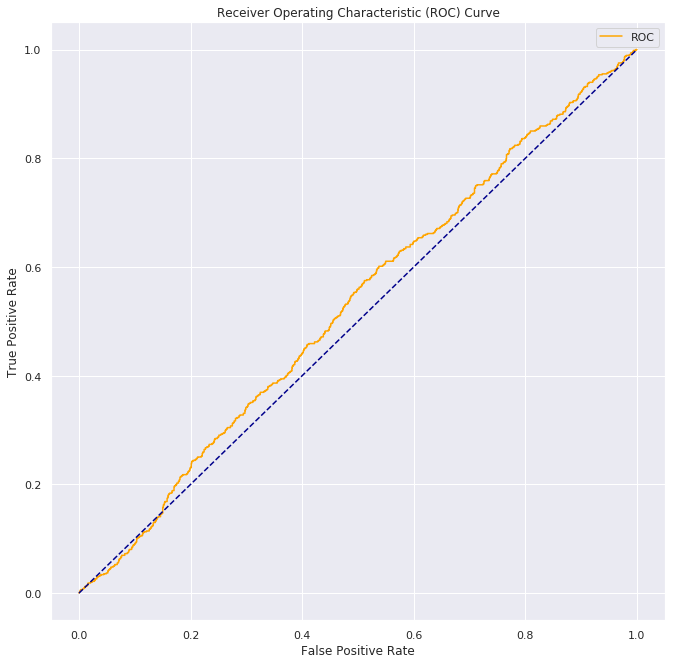

/home/divyanallamalli/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUC: 0.53


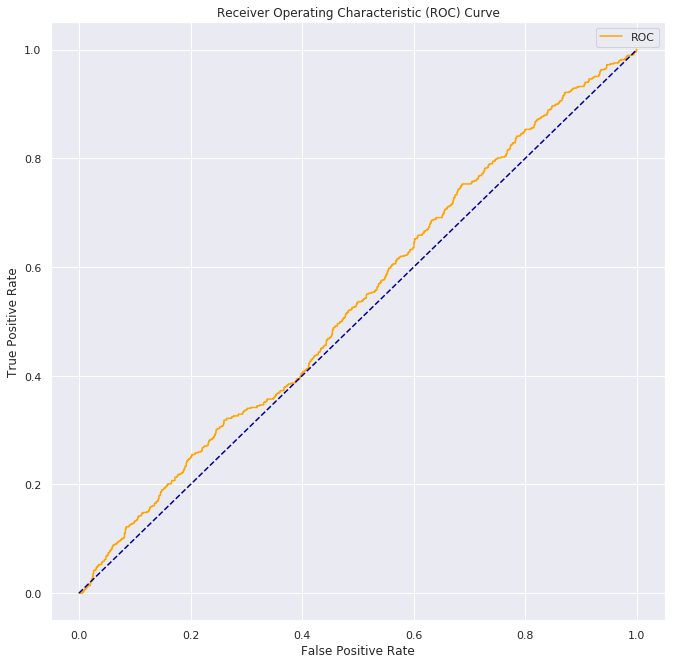

In [29]:
"""
Model evaluation across multiple classifiers based on accuracy of predictions.
"""
classifiers = [
    KNeighborsClassifier(3),
#     LinearSVC(),
#     DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LogisticRegression()]

acc_dict = {}

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

# sss.split gives lists of train and test indexes. iloc is done to get those rows from dataframe and store in train and test dataframes 
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    for clf in classifiers:
        name = clf.__class__.__name__
        clf.fit(X_train, y_train)
        train_predictions = clf.predict(X_test)
        acc = accuracy_score(y_test, train_predictions)
        
        probs = clf.predict_proba(X_test)
        probs = probs[:, 1]
        auc = roc_auc_score(y_test, probs)
        print('AUC: %.2f' % auc)
        fpr, tpr, thresholds = roc_curve(y_test, probs)  
        plot_roc_curve(fpr, tpr) 
        
        if name in acc_dict:
            acc_dict[name] += (acc/10.0)
        else:
            acc_dict[name] = (acc/10.0)

In [30]:
acc_dict

{'KNeighborsClassifier': 0.6505358615004122,
 'RandomForestClassifier': 0.7031739488870568,
 'AdaBoostClassifier': 0.732522671063479,
 'GradientBoostingClassifier': 0.7327699917559769,
 'GaussianNB': 0.2668590272052762,
 'LogisticRegression': 0.7333058532563892}

In [31]:
clf = LogisticRegression()
clf.fit(X_train,y_train)
predictions = clf.predict(all_test_features[all_test_features.columns[1:]])
output=pd.DataFrame({'patientID':all_test_features['patientID'],'Target':predictions})

/home/divyanallamalli/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [32]:
output['Target'] = lb.inverse_transform(output['Target'])

In [33]:
output.head()

,patientID,Target
24256,PT456611,No
24257,PT956824,No
24258,PT453330,No
24259,PT677563,No
24260,PT102924,No
